In [1]:
from paths import models_folder, metadata_folder

In [2]:
from pyobsbox import ObsBoxGenerator

In [3]:
import logging
import keras
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

In [4]:
logging.getLogger("pyobsbox").setLevel(logging.INFO)

# List models

In [5]:
list(models_folder.glob('model_*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_20756'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_1024'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_1'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_20608'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_time_dist_32_16_B1H_Inst_500'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_8_B1H_Inst_252'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_16_8_stride_4_B1H_Inst_253'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst_jorg'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_8_strid

In [6]:
model_path = models_folder / "model_conv_32_16_8_stride_4_B1H_Inst_presplit_center_scale_1000_seed_42"

In [7]:
list(model_path.glob('*fetched*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_8_stride_4_B1H_Inst_presplit_center_scale_1000_seed_42/validation_fetched.npy'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_8_stride_4_B1H_Inst_presplit_center_scale_1000_seed_42/train_fetched.npy')]

# Load model and associated generators

In [8]:
model = keras.models.load_model(model_path)
model.summary()
model_metadata = json.load((model_path / "metadata.json").open('r'))
data_metadata_path = model_metadata["generator"]["metadata_path"]

# load the data metadata
data_metadata_df = pd.read_hdf(data_metadata_path)

# load the indices of the data seen by the model
train_seen_indices = np.load(model_path / "train_fetched.npy")
validation_seen_indices = np.load(model_path / "validation_fetched.npy")

# train/validation split
# train_split_indices = np.load(model_path / "train_split_indices.npy")
# validation_split_indices = np.load(model_path / "validation_split_indices.npy")

# load the data seen by the model
train_metadata = data_metadata_df.iloc[train_seen_indices]
validation_metadata = data_metadata_df.iloc[validation_seen_indices]

# the training loss history
hist = model_metadata["history"]

# remove shuffling
model_metadata["generator"]["shuffle"] = True  # True because I don't have the seen values indices
# create the generators
train_generator = ObsBoxGenerator(train_metadata,
                                  **model_metadata["generator"])
validation_generator = ObsBoxGenerator(validation_metadata,
                                       **model_metadata["generator"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 512, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 512, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 16)           3600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 8)             904       
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 128, 8)            456       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 8)            0

Feb/23 15:06:20 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
Feb/23 15:06:20 pyobsbox.generator INFO: shuffle: True
Feb/23 15:06:20 pyobsbox.generator INFO: seed: 42
Feb/23 15:06:20 pyobsbox.generator INFO: batch_size: 8192
Feb/23 15:06:20 pyobsbox.generator INFO: sequence_length: 2048
Feb/23 15:06:20 pyobsbox.generator INFO: n_bunches: 256
Feb/23 15:06:20 pyobsbox.generator INFO: __len__: 1041
Feb/23 15:06:20 pyobsbox.generator INFO: fetched_log_folder: None
Feb/23 15:06:20 pyobsbox.generator INFO: fetched_log_prefix: 
Feb/23 15:06:20 pyobsbox.generator INFO: normalization: center_scale
Feb/23 15:06:20 pyobsbox.generator INFO: normalization_pre_split: True
Feb/23 15:06:20 pyobsbox.generator INFO: normalization_kwargs: {'scale_factor': 1000}
Feb/23 15:06:20 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
Feb/23 15:06:20 pyobsbox.

In [9]:
print(train_metadata.shape)
train_metadata.head()

(266496, 11)


type  fill  beam plane  q           date_time  \
7246169  Inst  6919     1     h  7 2018-07-13 18:25:14   
6889693  Inst  7464     1     h  7 2018-11-22 05:09:14   
1617372  Inst  6663     1     h  7 2018-05-10 15:13:15   
6142505  Inst  6953     1     h  7 2018-07-21 06:32:07   
593973   Inst  6245     1     h  7 2017-09-26 15:54:15   

                                                      file  n_bunches  \
7246169  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6919/...       2556   
6889693  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7464/...        460   
1617372  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6663/...       2556   
6142505  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6953/...       2556   
593973   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6245/...       1916   

         bunch_index  bunch_number  ts_length  
7246169        473.0         334.0      65536  
6889693        560.0          71.0      65536  
1617372       1334.0         961.0      65536  
6142505        994.0         723.0      65536  
593973        2879.0        1580.0      65536

In [10]:
print(validation_metadata.shape)
validation_metadata.head()

(3840, 11)


type  fill  beam plane  q           date_time  \
1560390  Inst  6860     1     h  7 2018-06-28 17:38:59   
7293972  Inst  7271     1     h  7 2018-10-09 17:17:46   
5117208  Inst  6700     1     h  7 2018-05-19 12:31:14   
6671723  Inst  6344     1     h  7 2017-10-28 22:49:14   
8952646  Inst  6707     1     h  7 2018-05-20 14:34:24   

                                                      file  n_bunches  \
1560390  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6860/...       2460   
7293972  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7271/...        780   
5117208  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6700/...       2556   
6671723  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6344/...       1868   
8952646  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6707/...       1068   

         bunch_index  bunch_number  ts_length  
1560390       1893.0        1394.0      65536  
7293972       1054.0         776.0      65536  
5117208       3353.0        2484.0      65536  
6671723        514.0         277.0      65536  
8952646        352.0         232.0      65536

# Loss functions

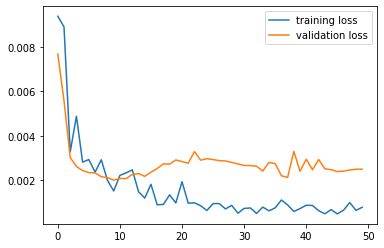

In [11]:
plt.plot(hist['loss'], label='training loss')
plt.plot(hist['val_loss'], label='validation loss')
plt.legend()

# Datasets

Load the first few batches

In [12]:
train_dataset = np.vstack([train_generator[i][0] for i in tqdm(range(50))])
train_dataset.shape

(409600, 2048, 1)

In [13]:
validation_dataset = np.vstack([validation_generator[i][0] for i in tqdm(range(5))])
validation_dataset.shape

(40960, 2048, 1)

# Predictions

In [14]:
train_pred = model.predict(train_dataset, verbose=1, batch_size=train_generator.batch_size)
train_pred.shape

50/50 [==============================] - 55s 1s/step


(409600, 2048, 1)

In [15]:
validation_pred = model.predict(validation_dataset, verbose=1, batch_size=validation_generator.batch_size)
validation_pred.shape

5/5 [==============================] - 4s 866ms/step


(40960, 2048, 1)

In [16]:
MAE_train = abs(train_pred - train_dataset).mean(axis=1).squeeze()
MAE_train.shape

(409600,)

In [17]:
MAE_validation = abs(validation_pred - validation_dataset).mean(axis=1).squeeze()
MAE_validation.shape

(40960,)

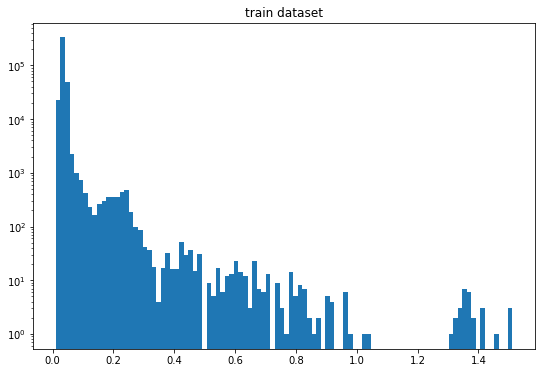

In [18]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_train, bins=100)
plt.title("train dataset")
plt.yscale('log')

rough peak

In [19]:
hist_peak_train = bins[n.argmax()]
hist_peak_train

0.02576230243214639

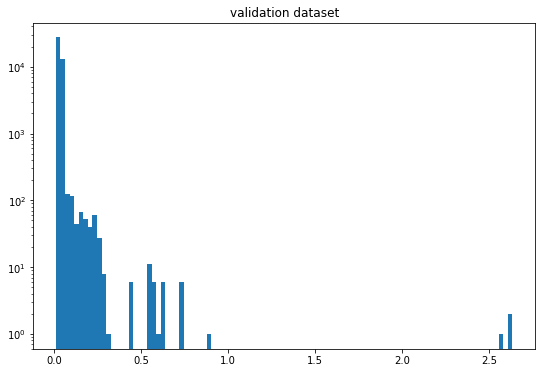

In [20]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_validation, bins=100)
plt.title("validation dataset")
plt.yscale('log')

In [21]:
hist_peak_validation = bins[n.argmax()]
hist_peak_validation

0.010497761943202932

In [22]:
max_MAE_indices = np.argsort(MAE_train)[::-1]

In [23]:
max_MAE_indices

array([103160, 103301, 105957, ..., 240798, 134100, 133563])

In [24]:
def plot_true_pred(true_signal, pred_signal):
    fig, axes = plt.subplots(2, figsize=(16, 6))
    axes[0].plot(true_signal)
    axes[0].plot(pred_signal)

    axes[1].plot(np.abs(np.diff(true_signal)))
    axes[1].plot(np.abs(np.diff(pred_signal)))
    return fig, axes

index:  103160
MAE:  1.511811368581606
n_bunches        480
bunch_index     1578
bunch_number     294
Name: 1879644, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7454/instability_data/07454_Inst_B1H_Q7_20181118_23h35m14s.h5


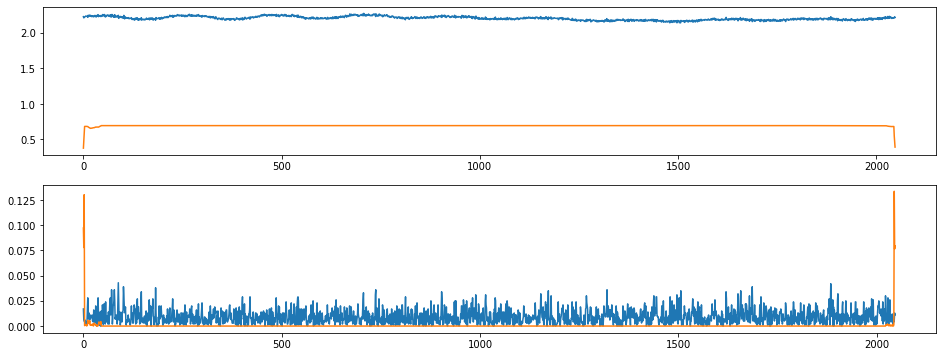

In [25]:
anomalous = 0
anomalous_index = max_MAE_indices[anomalous]

print('index: ', anomalous_index)
print("MAE: ", MAE_train[anomalous_index])
# I'm not sure this row is correct
metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
print(metadata_row['file'])

true_signal = train_dataset[anomalous_index].squeeze()
pred_signal = train_pred[anomalous_index].squeeze()

plot_true_pred(true_signal, pred_signal);

# Top rightmost signals

index:  103160
MAE:  1.511811368581606
n_bunches        480
bunch_index     1578
bunch_number     294
Name: 1879644, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7454/instability_data/07454_Inst_B1H_Q7_20181118_23h35m14s.h5


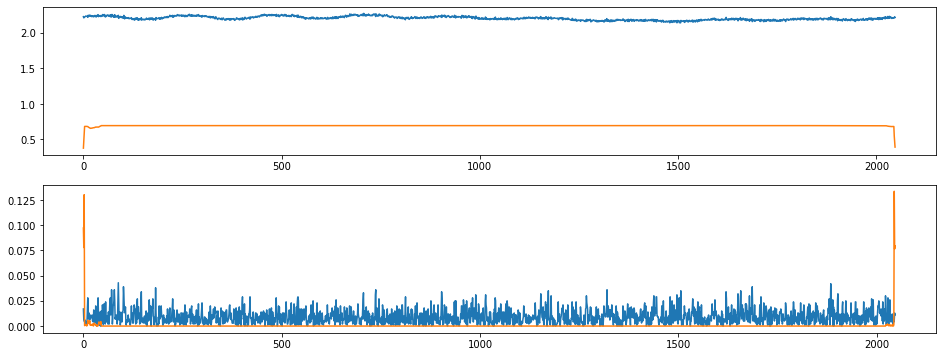

index:  103301
MAE:  1.5045875876722856
n_bunches        734
bunch_index     2546
bunch_number     536
Name: 7417989, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6881/instability_data/06881_Inst_B1H_Q7_20180703_07h02m15s.h5


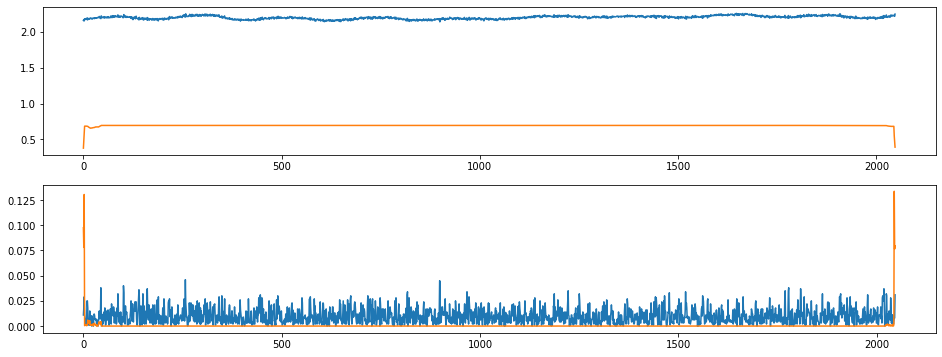

index:  105957
MAE:  1.4976939398422837
n_bunches       804
bunch_index     148
bunch_number    104
Name: 2339938, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6602/instability_data/06602_Inst_B1H_Q7_20180423_17h06m10s.h5


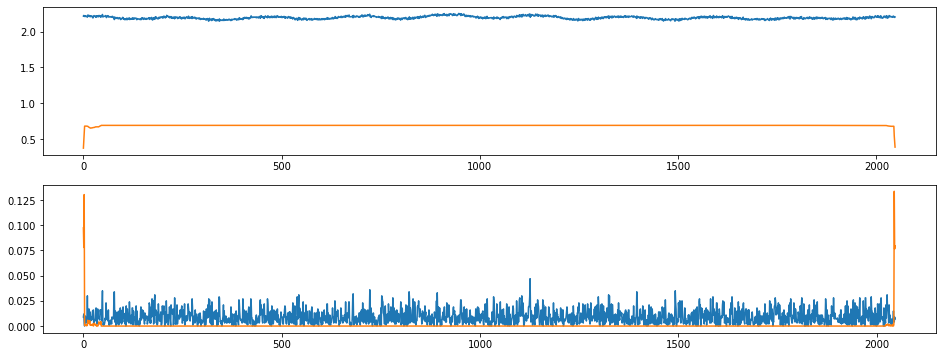

index:  99855
MAE:  1.4571613416195615
n_bunches        670
bunch_index     1897
bunch_number     399
Name: 6256084, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7466/instability_data/07466_Inst_B1H_Q7_20181122_20h46m15s.h5


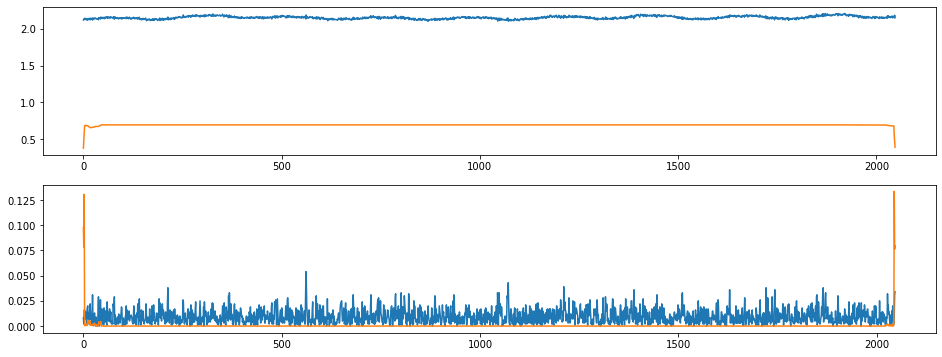

index:  95560
MAE:  1.4094788508457126
n_bunches       876
bunch_index     759
bunch_number    219
Name: 228975, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6788/instability_data/06788_Inst_B1H_Q7_20180613_22h24m14s.h5


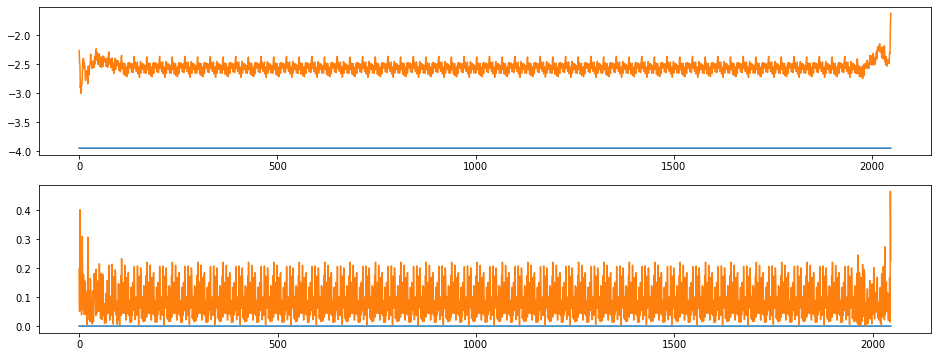

index:  91732
MAE:  1.4094788508457126
n_bunches       780
bunch_index     410
bunch_number    278
Name: 10963584, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7333/instability_data/07333_Inst_B1H_Q7_20181022_22h14m15s.h5


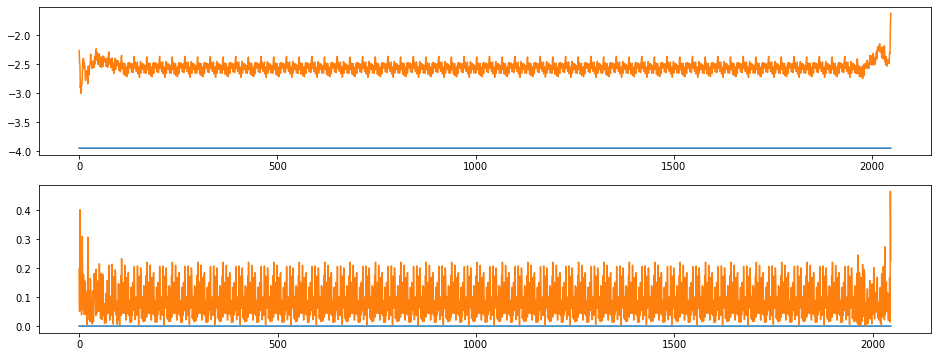

index:  94260
MAE:  1.4094788508457126
n_bunches       780
bunch_index     329
bunch_number    228
Name: 8518266, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7310/instability_data/07310_Inst_B1H_Q7_20181017_06h52m19s.h5


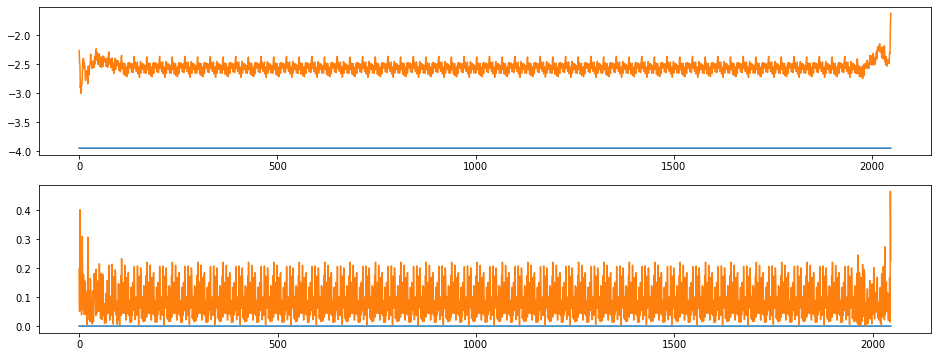

index:  24415
MAE:  1.3831546982721195
n_bunches       157
bunch_index     230
bunch_number     82
Name: 11206170, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6432/instability_data/06432_Inst_B1H_Q7_20171129_01h29m14s.h5


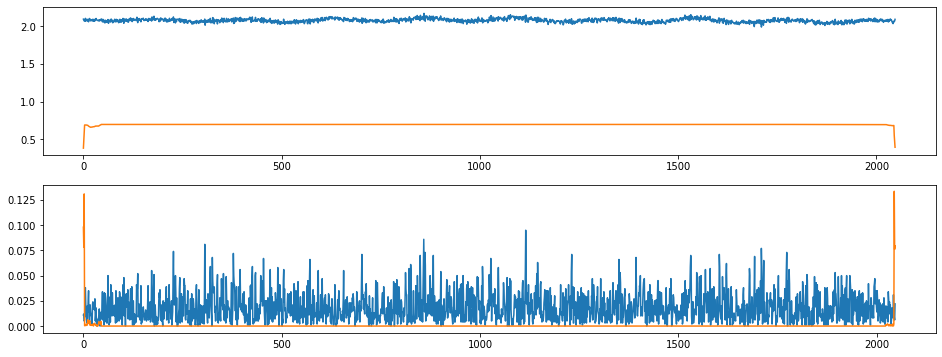

index:  88290
MAE:  1.3827339003685628
n_bunches       540
bunch_index     460
bunch_number    321
Name: 1157467, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7316/instability_data/07316_Inst_B1H_Q7_20181019_06h48m09s.h5


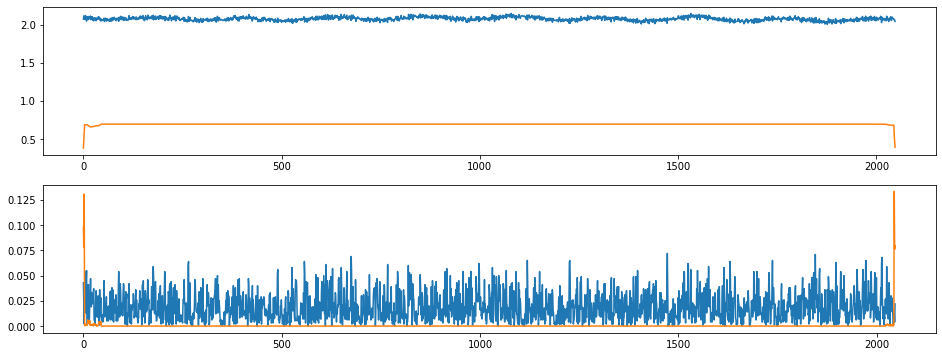

index:  16871
MAE:  1.3706158905474004
n_bunches       108
bunch_index     151
bunch_number     95
Name: 1357598, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7321/instability_data/07321_Inst_B1H_Q7_20181020_08h53m30s.h5


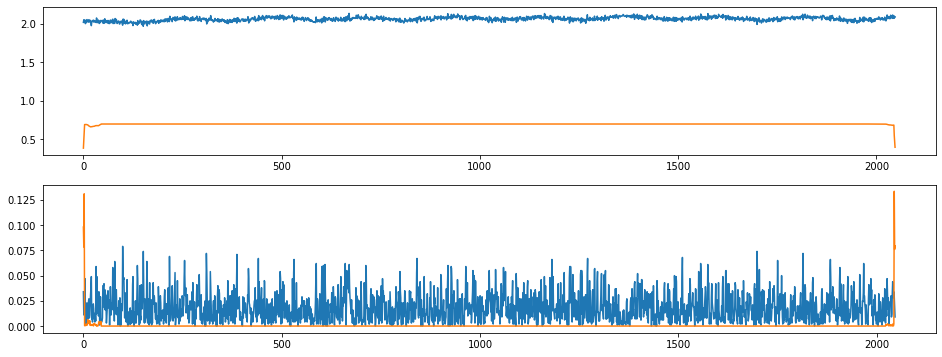

In [26]:
for i in range(10):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# Top leftmost signals

index:  133563
MAE:  0.010751705804374068
n_bunches       2556
bunch_index     1665
bunch_number    1217
Name: 3208561, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7117/instability_data/07117_Inst_B1H_Q7_20180902_05h32m15s.h5


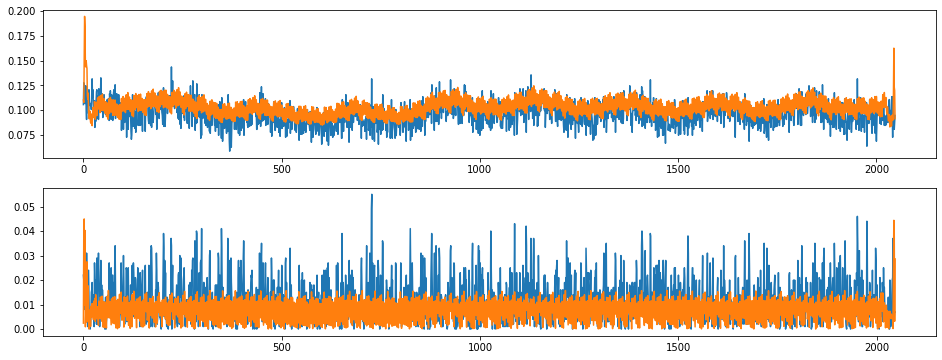

index:  134100
MAE:  0.010834501356381223
n_bunches        408
bunch_index     2280
bunch_number     395
Name: 10424538, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6436/instability_data/06436_Inst_B1H_Q7_20171130_02h49m01s.h5


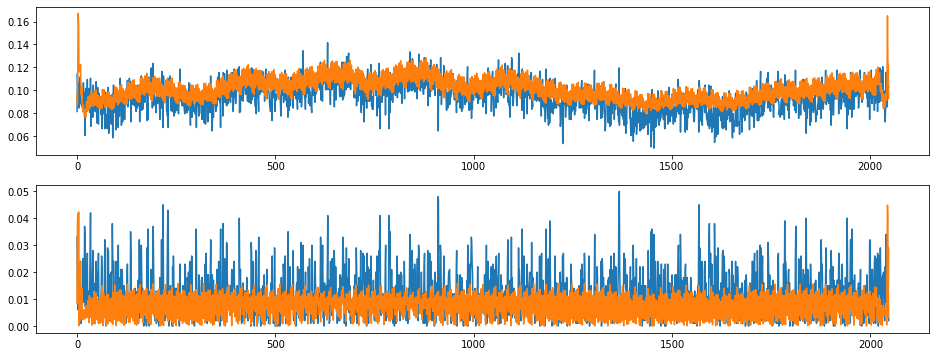

index:  240798
MAE:  0.010853390234522522
n_bunches       276
bunch_index     361
bunch_number     65
Name: 1547884, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7446/instability_data/07446_Inst_B1H_Q7_20181115_18h57m03s.h5


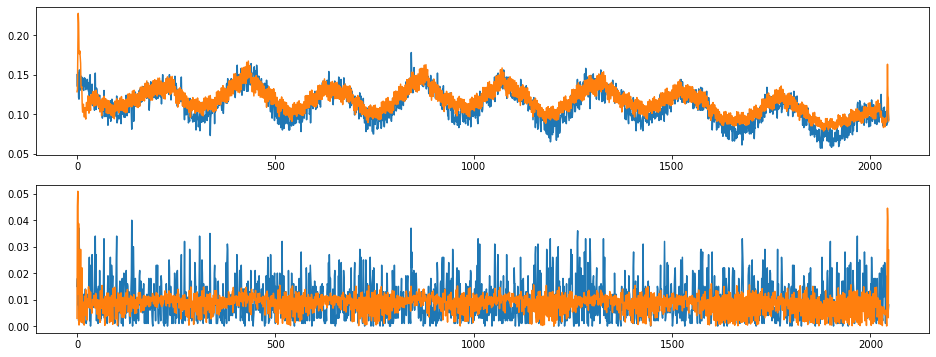

index:  162701
MAE:  0.010890267410053639
n_bunches       168
bunch_index     291
bunch_number     59
Name: 7020944, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7306/instability_data/07306_Inst_B1H_Q7_20181015_06h19m37s.h5


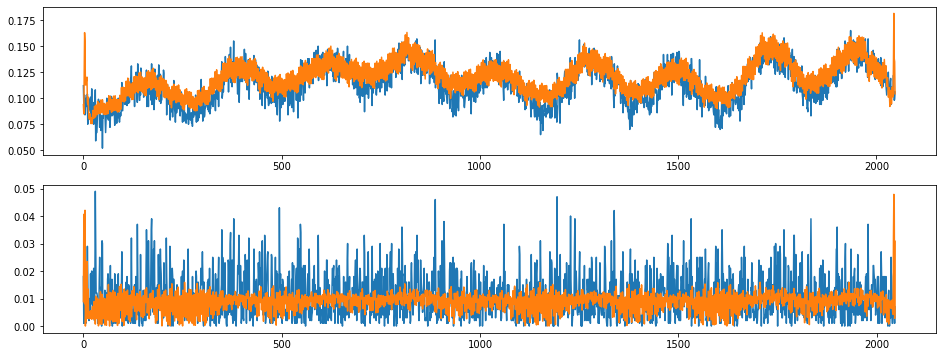

index:  331867
MAE:  0.010942606134776725
n_bunches        260
bunch_index     1962
bunch_number     153
Name: 2453998, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7433/instability_data/07433_Inst_B1H_Q7_20181110_01h07m14s.h5


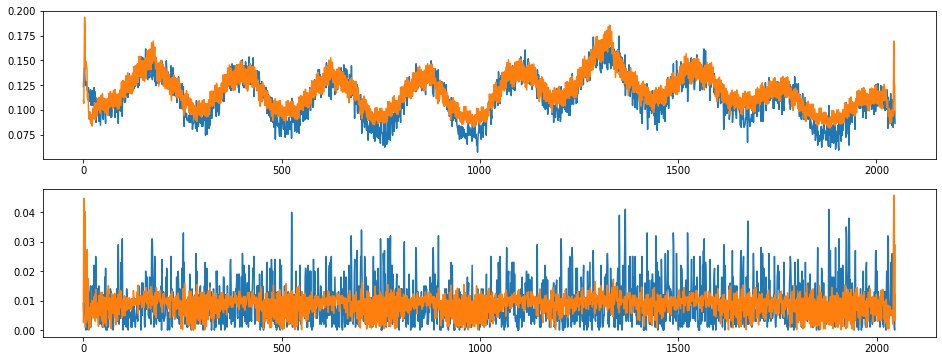

index:  156166
MAE:  0.010943621324870038
n_bunches       1868
bunch_index       59
bunch_number      22
Name: 326667, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6356/instability_data/06356_Inst_B1H_Q7_20171101_23h31m14s.h5


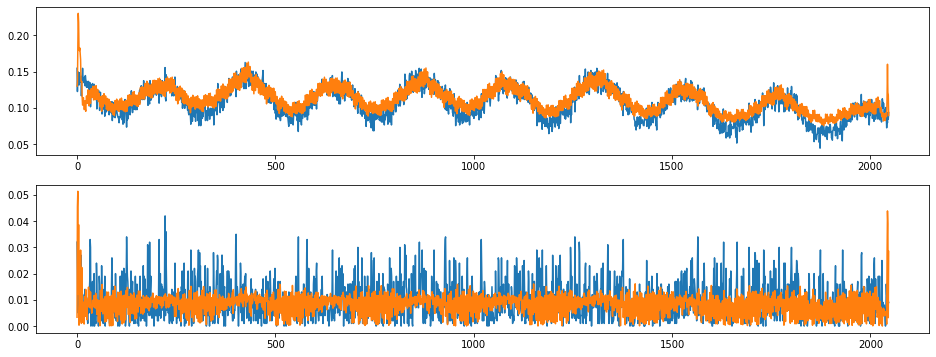

index:  131969
MAE:  0.010948267335101264
n_bunches       157
bunch_index     148
bunch_number     39
Name: 5348028, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6432/instability_data/06432_Inst_B1H_Q7_20171128_22h53m14s.h5


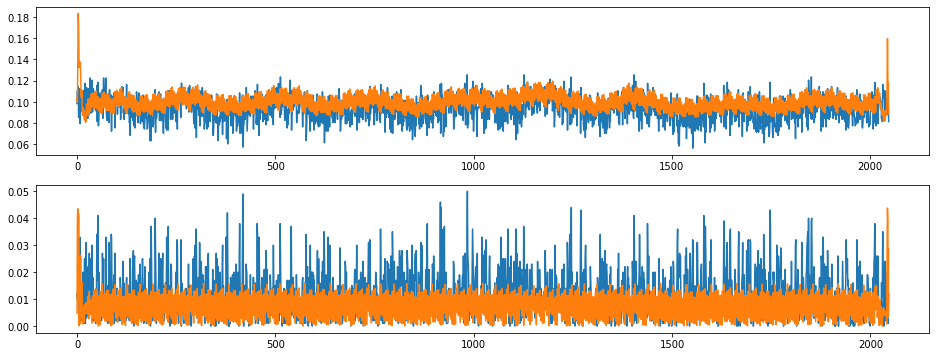

index:  274349
MAE:  0.010970405410655075
n_bunches       636
bunch_index     137
bunch_number     62
Name: 5175675, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6765/instability_data/06765_Inst_B1H_Q7_20180607_13h49m00s.h5


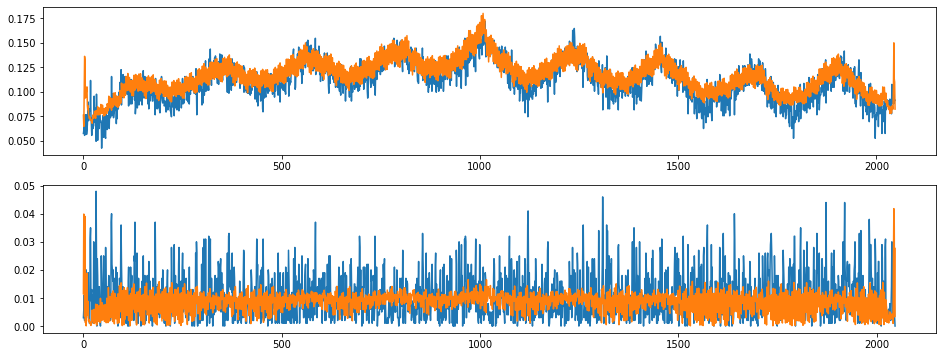

index:  110263
MAE:  0.010982525621016976
n_bunches       1868
bunch_index     2809
bunch_number    1499
Name: 11163672, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6351/instability_data/06351_Inst_B1H_Q7_20171031_16h22m14s.h5


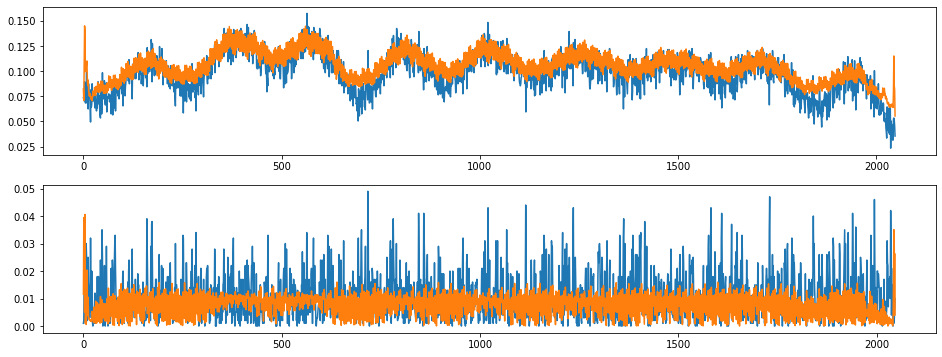

index:  167126
MAE:  0.011000381469202692
n_bunches       1227
bunch_index     1060
bunch_number     331
Name: 6412141, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_04h03m14s.h5


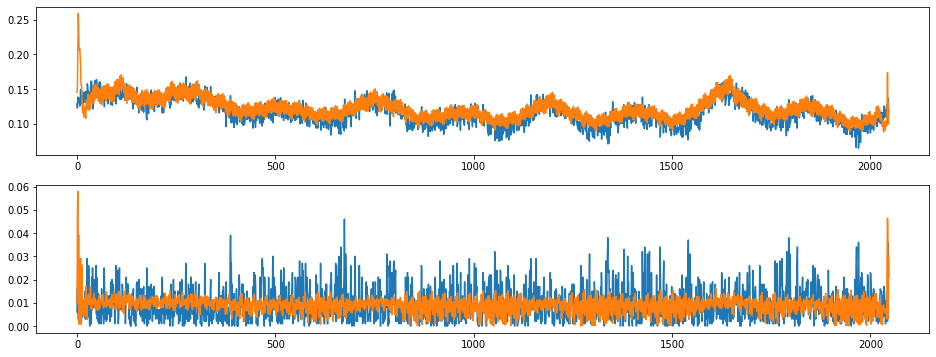

In [27]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# Signals around the peak

In [28]:
around_peak_indices = np.argsort(np.abs(MAE_train - hist_peak_train))

index:  132138
MAE:  0.02576215181983571
n_bunches       396
bunch_index     507
bunch_number    361
Name: 2585924, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7132/instability_data/07132_Inst_B1H_Q7_20180907_02h02m28s.h5


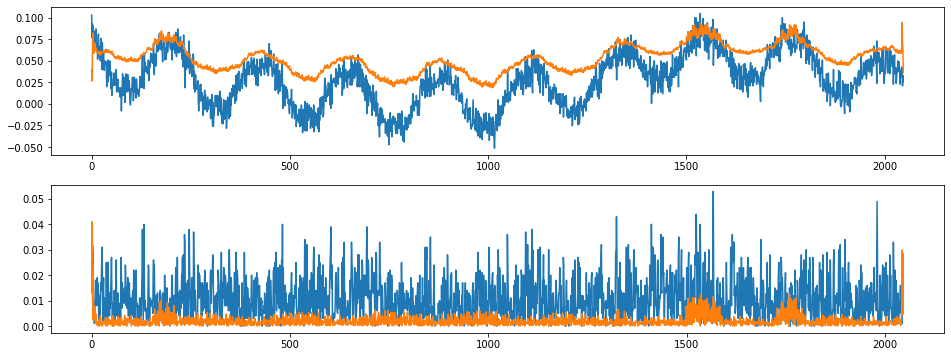

index:  231891
MAE:  0.02576253170502605
n_bunches       780
bunch_index      63
bunch_number     14
Name: 5166271, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6919/instability_data/06919_Inst_B1H_Q7_20180713_05h43m02s.h5


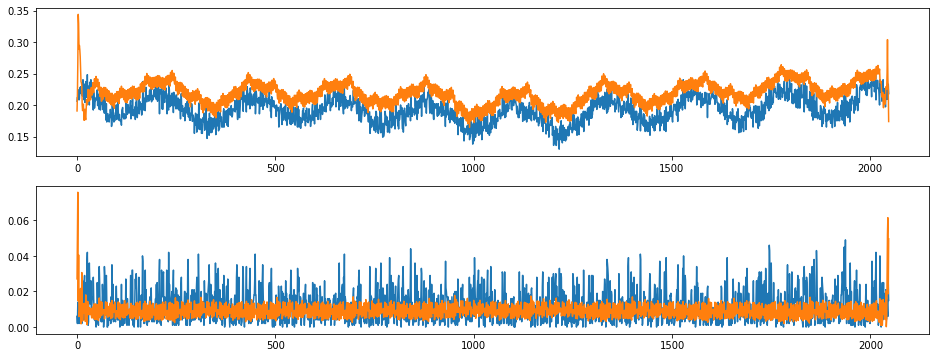

index:  274650
MAE:  0.02576192891899382
n_bunches       1836
bunch_index     1437
bunch_number     765
Name: 6035014, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6272/instability_data/06272_Inst_B1H_Q7_20171005_08h09m14s.h5


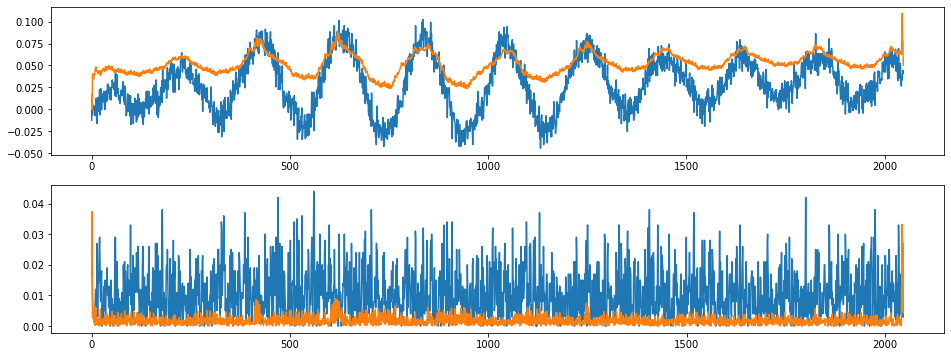

index:  242906
MAE:  0.02576275743009137
n_bunches       1868
bunch_index      888
bunch_number     468
Name: 1153008, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6283/instability_data/06283_Inst_B1H_Q7_20171008_07h32m14s.h5


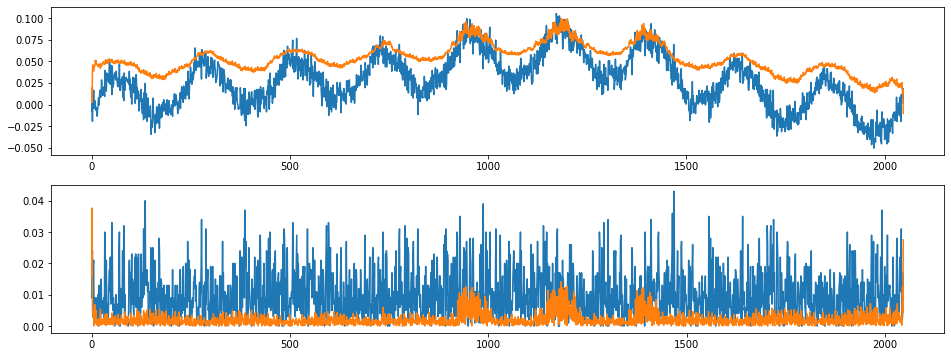

index:  352128
MAE:  0.02576177093525621
n_bunches       2556
bunch_index     3168
bunch_number    2363
Name: 9136077, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6923/instability_data/06923_Inst_B1H_Q7_20180714_21h35m14s.h5


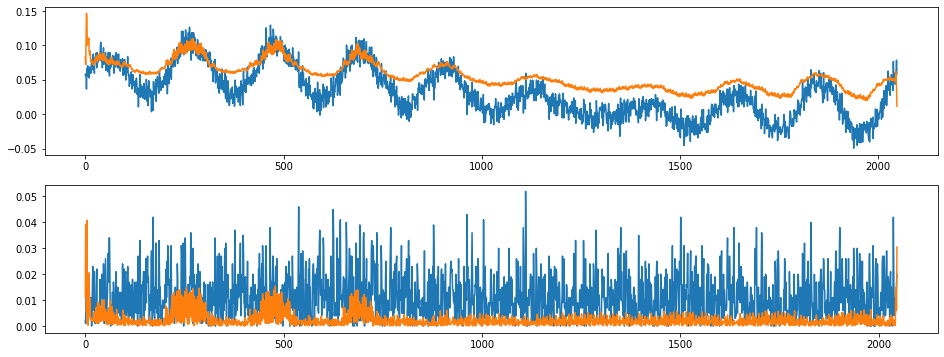

index:  395643
MAE:  0.025761652618588413
n_bunches       1292
bunch_index     1084
bunch_number     355
Name: 6827392, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6384/instability_data/06384_Inst_B1H_Q7_20171112_23h21m14s.h5


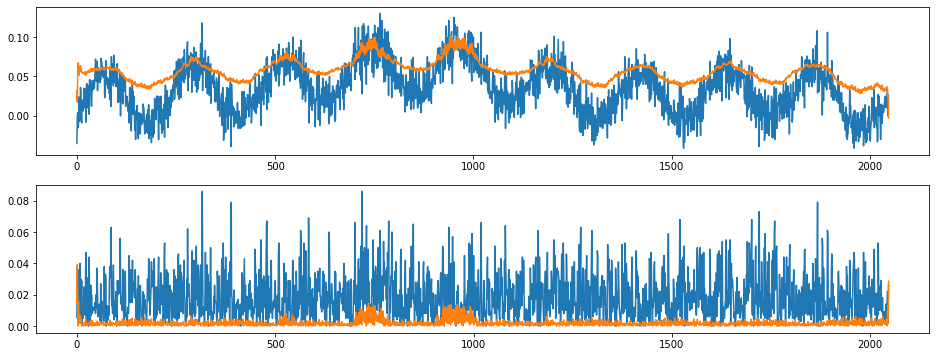

index:  77827
MAE:  0.025761491302195284
n_bunches       733
bunch_index     342
bunch_number     71
Name: 1698771, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7467/instability_data/07467_Inst_B1H_Q7_20181123_11h05m14s.h5


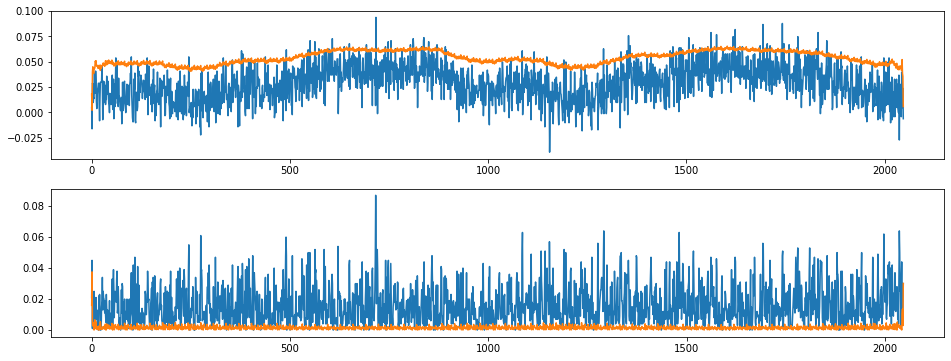

index:  96755
MAE:  0.025761479785911888
n_bunches       524
bunch_index     730
bunch_number    397
Name: 11583178, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6442/instability_data/06442_Inst_B1H_Q7_20171201_00h04m03s.h5


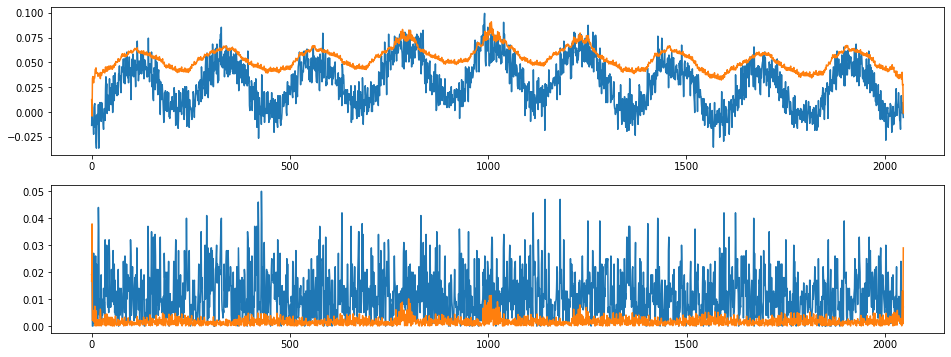

index:  330275
MAE:  0.02576128070201776
n_bunches        734
bunch_index     2171
bunch_number     426
Name: 10855713, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6885/instability_data/06885_Inst_B1H_Q7_20180704_20h53m56s.h5


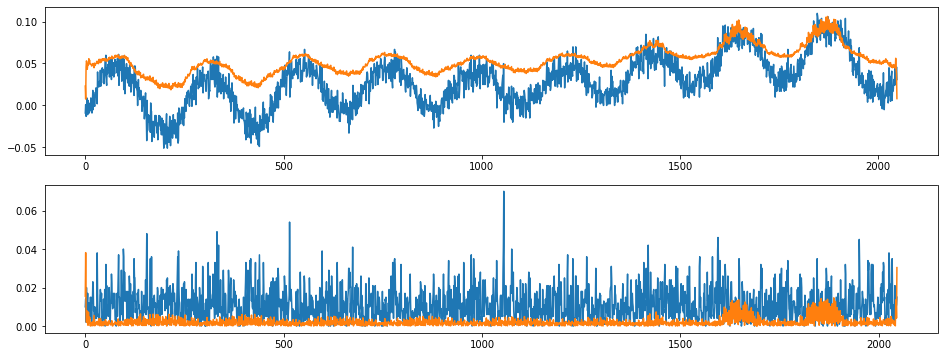

index:  220302
MAE:  0.025761111451451144
n_bunches       1916
bunch_index     1368
bunch_number     752
Name: 2347859, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/instability_data/06255_Inst_B1H_Q7_20170929_21h31m14s.h5


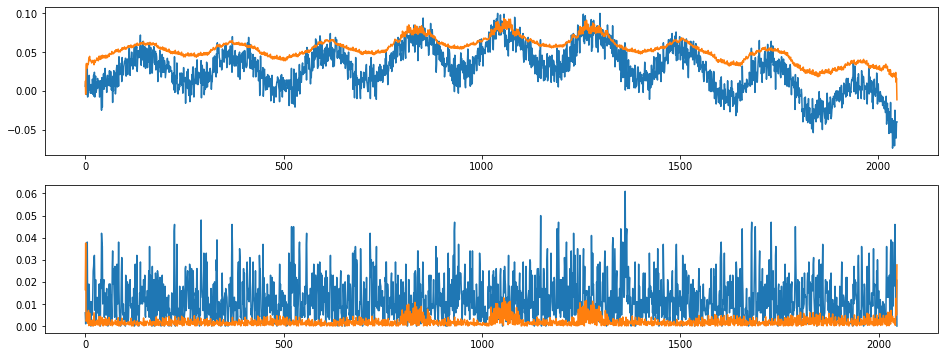

In [29]:
for i in range(10):
    around_peak_index = around_peak_indices[i]

    print('index: ', around_peak_index)
    print("MAE: ", MAE_train[around_peak_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[around_peak_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_peak_index].squeeze()
    pred_signal = train_pred[around_peak_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# around a point

In [30]:
around_point_indices = np.argsort(np.abs(MAE_train - 0.6))

index:  23241
MAE:  0.6012615001238882
n_bunches       264
bunch_index     393
bunch_number     31
Name: 7598900, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7155/instability_data/07155_Inst_B1H_Q7_20180912_23h59m05s.h5


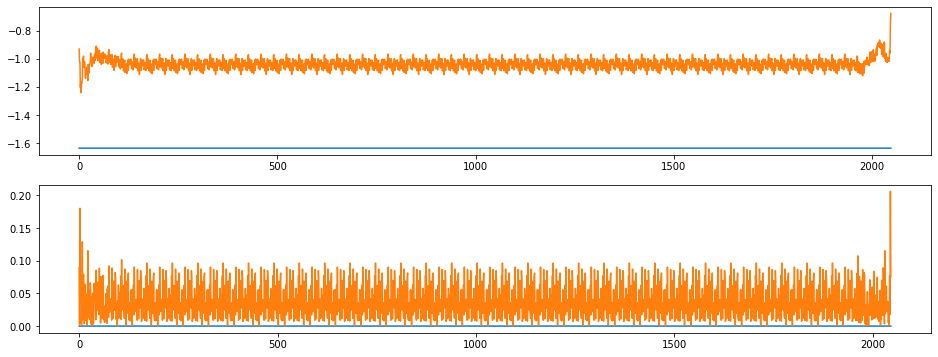

index:  20707
MAE:  0.6012615001238882
n_bunches       1868
bunch_index     3253
bunch_number    1747
Name: 7169010, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6275/instability_data/06275_Inst_B1H_Q7_20171006_09h17m26s.h5


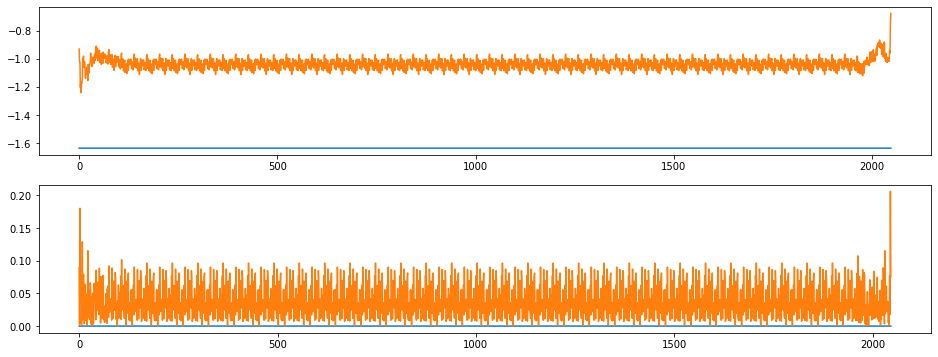

index:  22399
MAE:  0.6012615001238882
n_bunches       2556
bunch_index     3030
bunch_number    2263
Name: 9543845, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6956/instability_data/06956_Inst_B1H_Q7_20180721_18h38m30s.h5


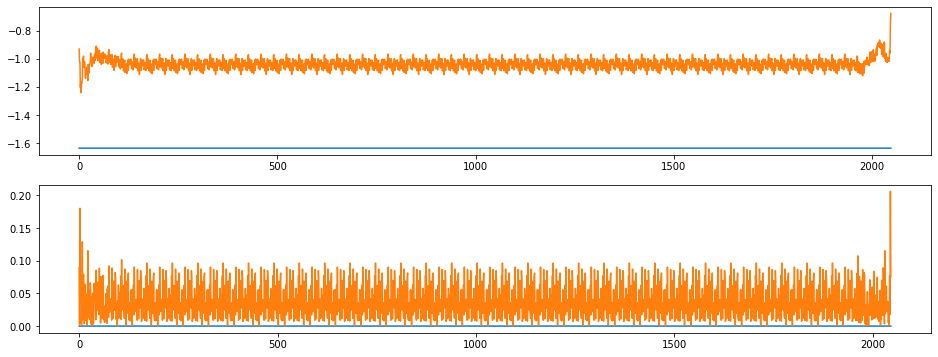

index:  18164
MAE:  0.6012615001238882
n_bunches       1551
bunch_index     1083
bunch_number     460
Name: 7857480, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6628/instability_data/06628_Inst_B1H_Q7_20180430_21h17m14s.h5


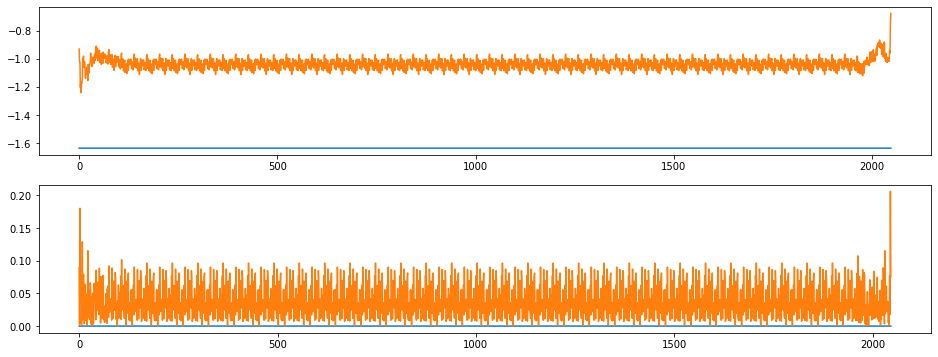

index:  21444
MAE:  0.6012615001238882
n_bunches       1916
bunch_index      308
bunch_number     164
Name: 3670702, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6193/instability_data/06193_Inst_B1H_Q7_20170913_00h56m14s.h5


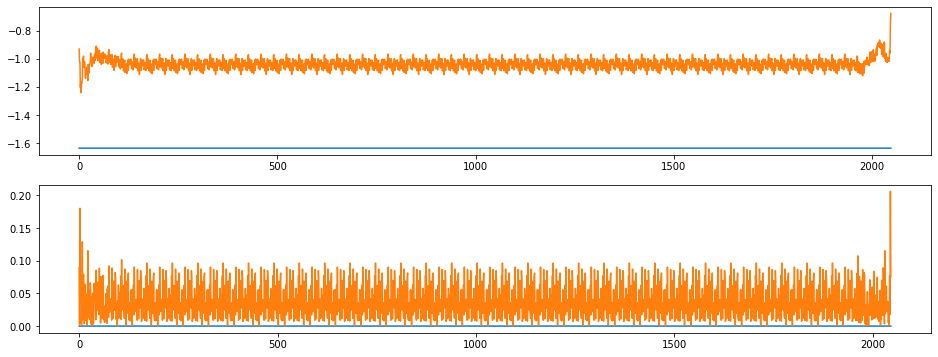

index:  19004
MAE:  0.6012615001238882
n_bunches       396
bunch_index     263
bunch_number    169
Name: 4472760, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7022/instability_data/07022_Inst_B1H_Q7_20180805_06h12m18s.h5


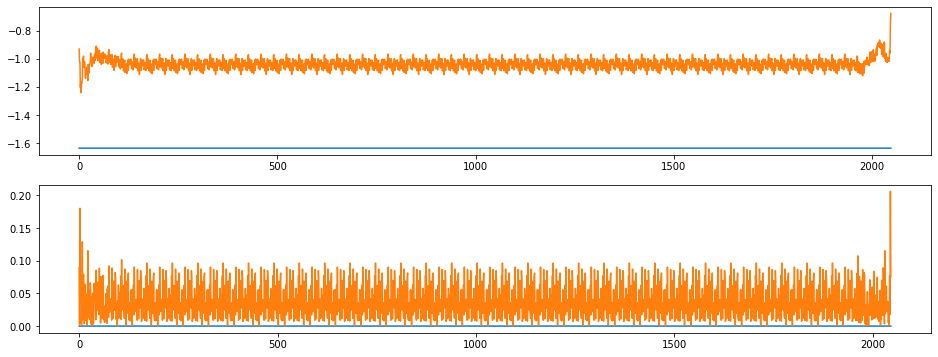

index:  249570
MAE:  0.5985393492653965
n_bunches       780
bunch_index     914
bunch_number    650
Name: 944056, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7124/instability_data/07124_Inst_B1H_Q7_20180904_06h54m19s.h5


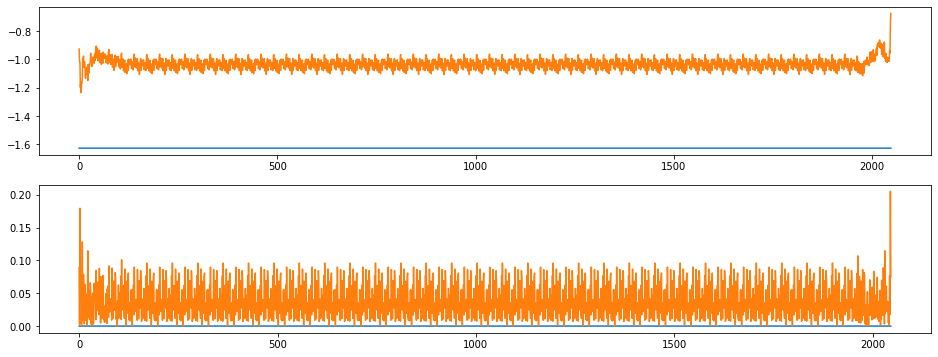

index:  250153
MAE:  0.5985393492653965
n_bunches       2556
bunch_index     2253
bunch_number    1670
Name: 1122441, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7052/instability_data/07052_Inst_B1H_Q7_20180813_16h51m15s.h5


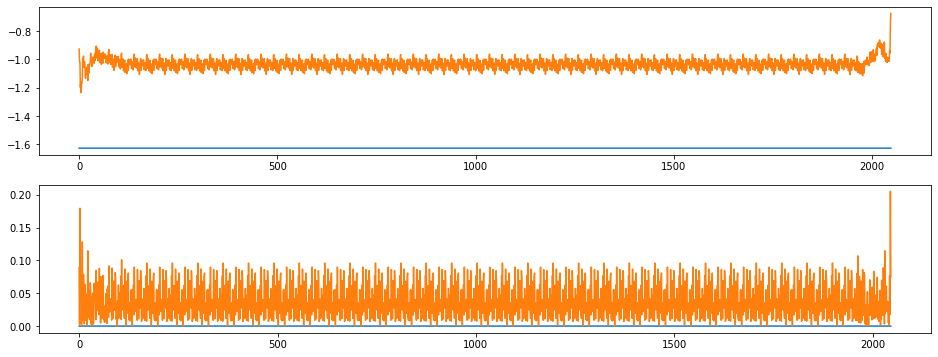

index:  249598
MAE:  0.5985393492653965
n_bunches       780
bunch_index     914
bunch_number    650
Name: 944056, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7124/instability_data/07124_Inst_B1H_Q7_20180904_06h54m19s.h5


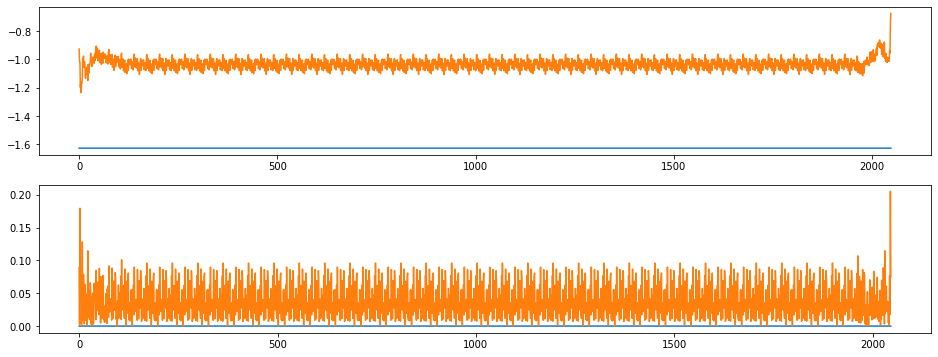

index:  249143
MAE:  0.5985393492653965
n_bunches        733
bunch_index     1918
bunch_number     404
Name: 38300, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7485/instability_data/07485_Inst_B1H_Q7_20181129_23h02m14s.h5


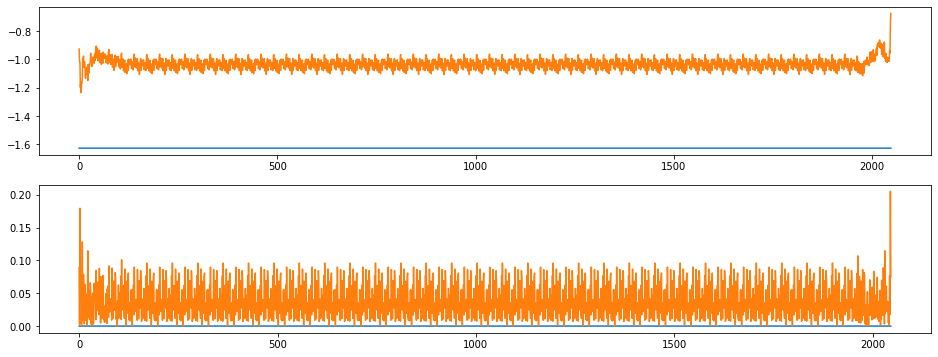

In [31]:
for i in range(10):
    around_point_index = around_point_indices[i]

    print('index: ', around_point_index)
    print("MAE: ", MAE_train[around_point_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[around_point_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_point_index].squeeze()
    pred_signal = train_pred[around_point_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# latent space encoding

In [32]:
import keras

In [33]:
encoding_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer('conv1d_2').output)

In [34]:
encoding_output = encoding_model(train_dataset[max_MAE_indices[-1]][None, :])
encoding_output.shape

TensorShape([1, 32, 8])

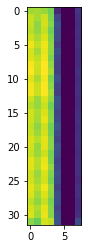

In [35]:
plt.imshow(np.array(encoding_output).squeeze())

# Latent space encoding of nominal signals

index:  133563
MAE:  0.010751705804374068
n_bunches       2556
bunch_index     1665
bunch_number    1217
Name: 3208561, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7117/instability_data/07117_Inst_B1H_Q7_20180902_05h32m15s.h5


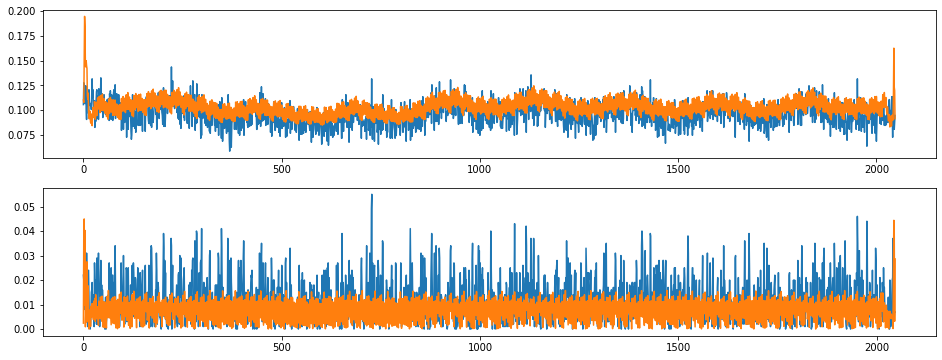

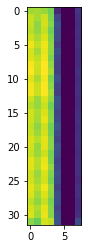

index:  134100
MAE:  0.010834501356381223
n_bunches        408
bunch_index     2280
bunch_number     395
Name: 10424538, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6436/instability_data/06436_Inst_B1H_Q7_20171130_02h49m01s.h5


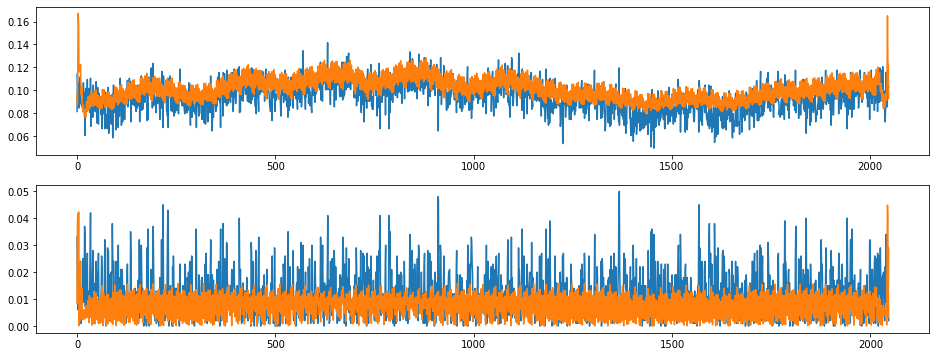

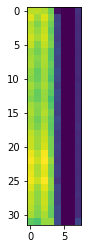

index:  240798
MAE:  0.010853390234522522
n_bunches       276
bunch_index     361
bunch_number     65
Name: 1547884, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7446/instability_data/07446_Inst_B1H_Q7_20181115_18h57m03s.h5


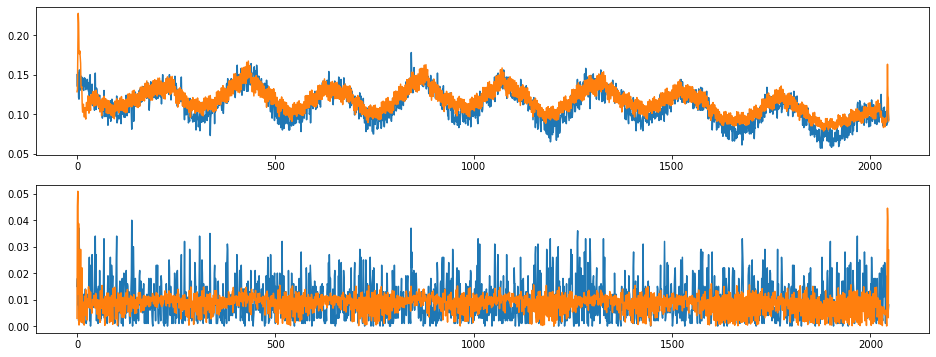

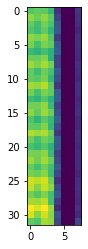

index:  162701
MAE:  0.010890267410053639
n_bunches       168
bunch_index     291
bunch_number     59
Name: 7020944, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7306/instability_data/07306_Inst_B1H_Q7_20181015_06h19m37s.h5


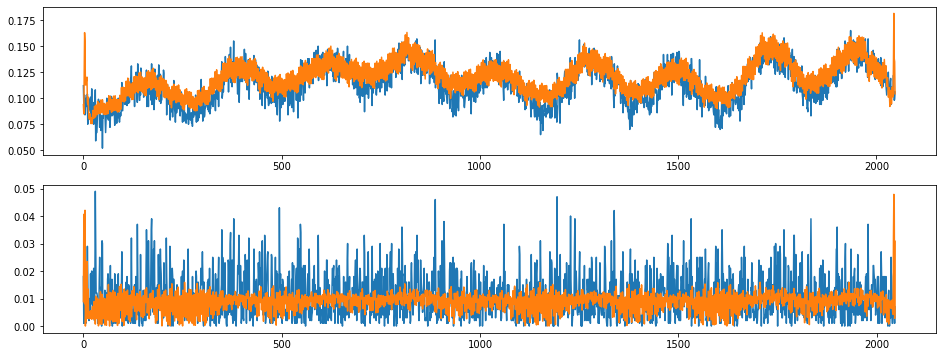

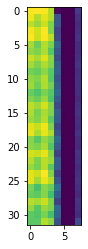

index:  331867
MAE:  0.010942606134776725
n_bunches        260
bunch_index     1962
bunch_number     153
Name: 2453998, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7433/instability_data/07433_Inst_B1H_Q7_20181110_01h07m14s.h5


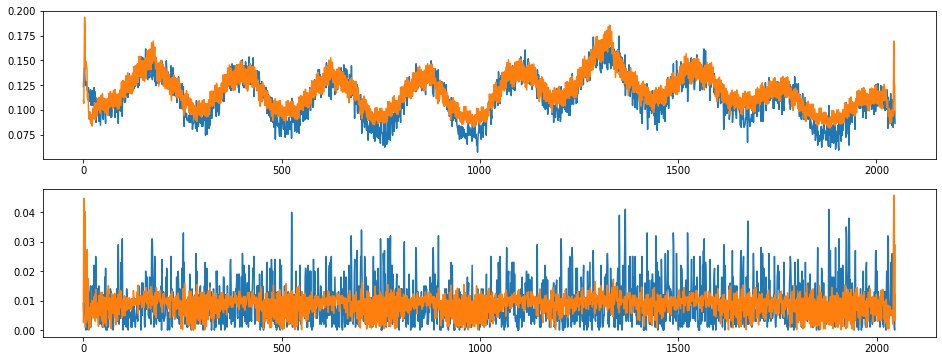

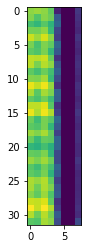

index:  156166
MAE:  0.010943621324870038
n_bunches       1868
bunch_index       59
bunch_number      22
Name: 326667, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6356/instability_data/06356_Inst_B1H_Q7_20171101_23h31m14s.h5


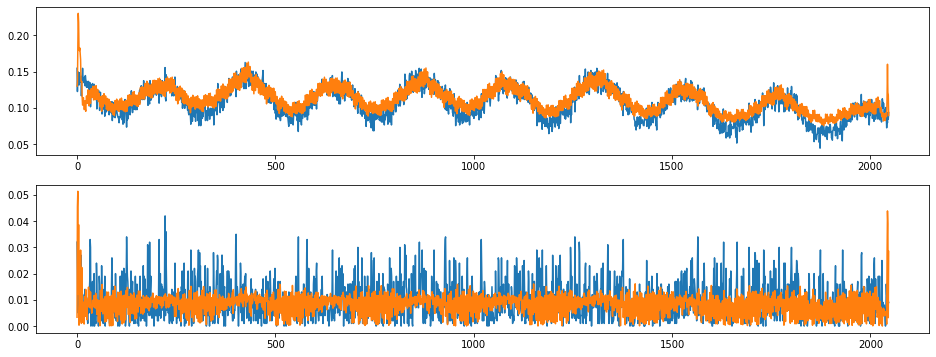

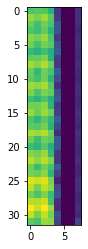

index:  131969
MAE:  0.010948267335101264
n_bunches       157
bunch_index     148
bunch_number     39
Name: 5348028, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6432/instability_data/06432_Inst_B1H_Q7_20171128_22h53m14s.h5


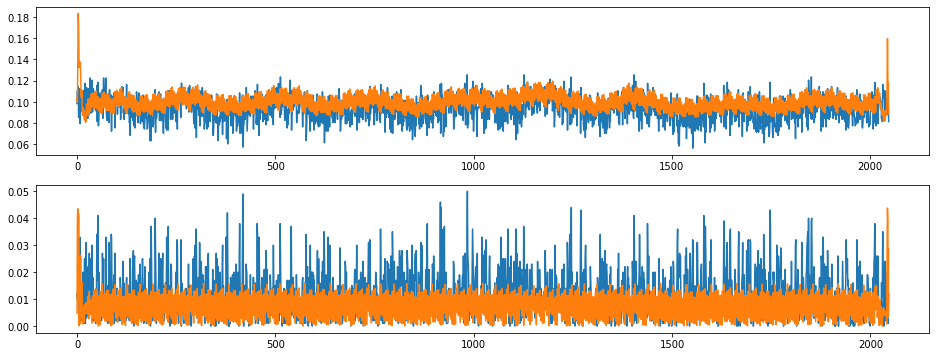

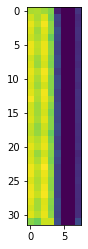

index:  274349
MAE:  0.010970405410655075
n_bunches       636
bunch_index     137
bunch_number     62
Name: 5175675, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6765/instability_data/06765_Inst_B1H_Q7_20180607_13h49m00s.h5


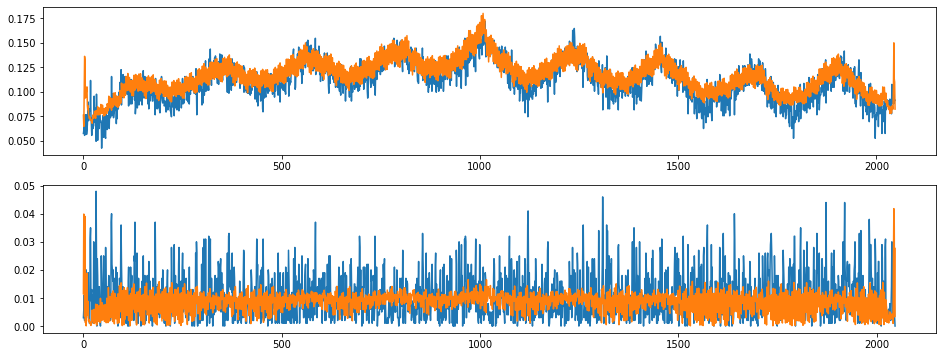

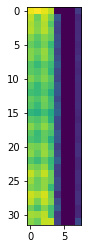

index:  110263
MAE:  0.010982525621016976
n_bunches       1868
bunch_index     2809
bunch_number    1499
Name: 11163672, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6351/instability_data/06351_Inst_B1H_Q7_20171031_16h22m14s.h5


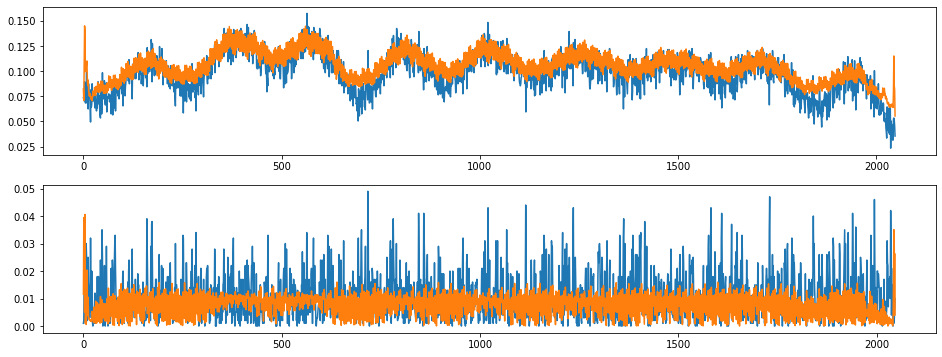

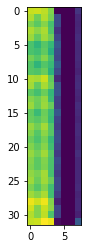

index:  167126
MAE:  0.011000381469202692
n_bunches       1227
bunch_index     1060
bunch_number     331
Name: 6412141, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_04h03m14s.h5


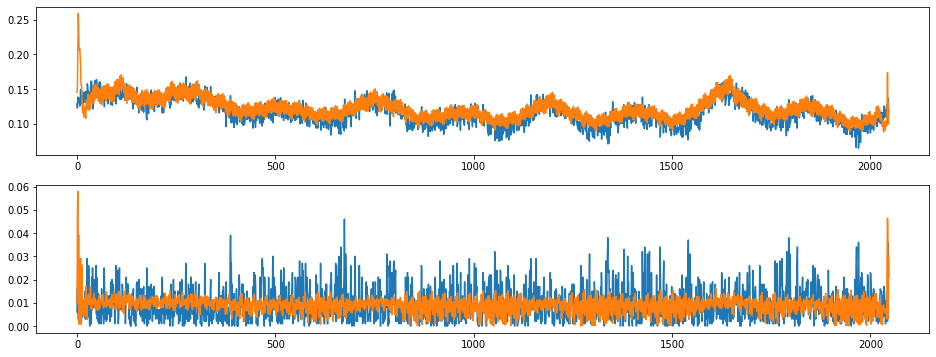

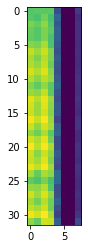

In [36]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]
    
    encoding_output = encoding_model(train_dataset[max_MAE_indices[left_most]][None, :])

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()

# Latent space encoding of anomalous signals

index:  103160
MAE:  1.511811368581606
n_bunches        480
bunch_index     1578
bunch_number     294
Name: 1879644, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7454/instability_data/07454_Inst_B1H_Q7_20181118_23h35m14s.h5


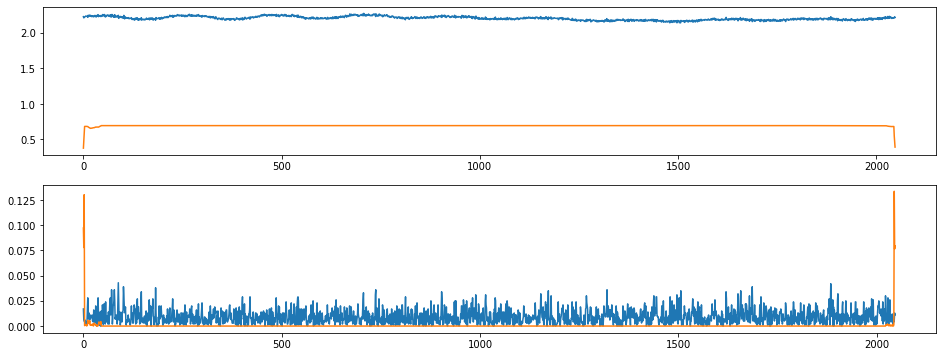

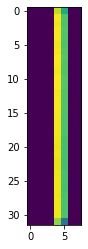

index:  103301
MAE:  1.5045875876722856
n_bunches        734
bunch_index     2546
bunch_number     536
Name: 7417989, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6881/instability_data/06881_Inst_B1H_Q7_20180703_07h02m15s.h5


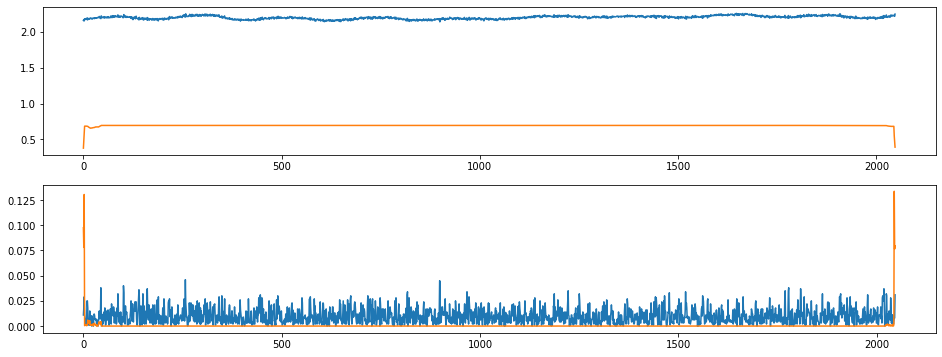

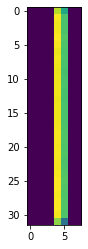

index:  105957
MAE:  1.4976939398422837
n_bunches       804
bunch_index     148
bunch_number    104
Name: 2339938, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6602/instability_data/06602_Inst_B1H_Q7_20180423_17h06m10s.h5


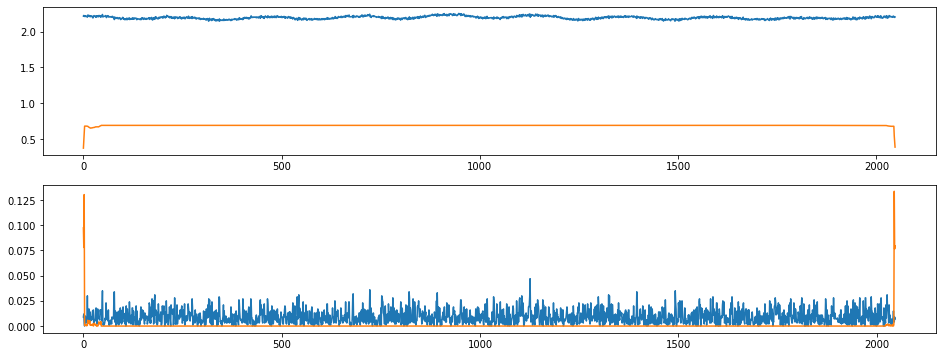

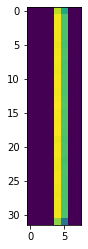

index:  99855
MAE:  1.4571613416195615
n_bunches        670
bunch_index     1897
bunch_number     399
Name: 6256084, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7466/instability_data/07466_Inst_B1H_Q7_20181122_20h46m15s.h5


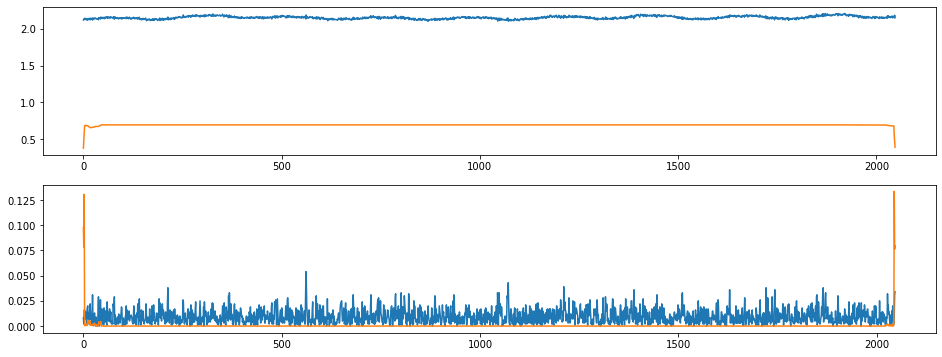

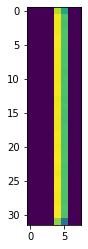

index:  95560
MAE:  1.4094788508457126
n_bunches       876
bunch_index     759
bunch_number    219
Name: 228975, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6788/instability_data/06788_Inst_B1H_Q7_20180613_22h24m14s.h5


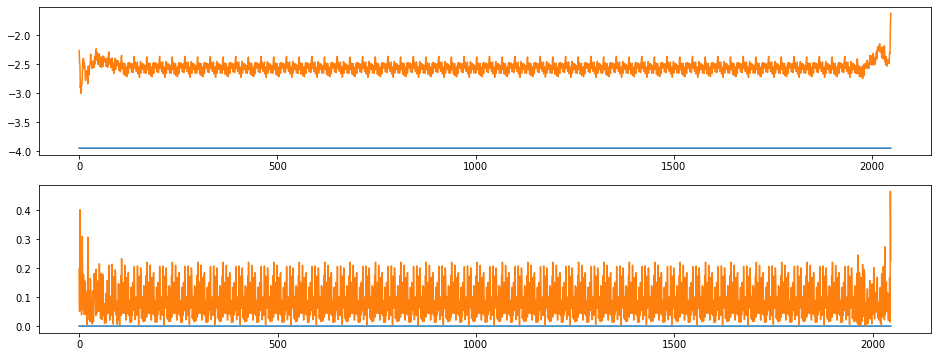

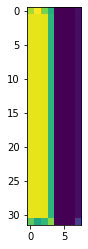

index:  91732
MAE:  1.4094788508457126
n_bunches       780
bunch_index     410
bunch_number    278
Name: 10963584, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7333/instability_data/07333_Inst_B1H_Q7_20181022_22h14m15s.h5


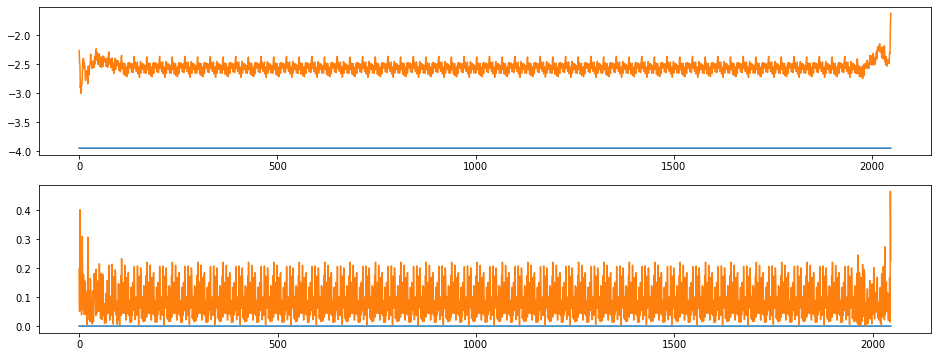

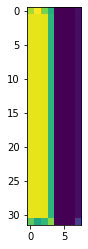

index:  94260
MAE:  1.4094788508457126
n_bunches       780
bunch_index     329
bunch_number    228
Name: 8518266, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7310/instability_data/07310_Inst_B1H_Q7_20181017_06h52m19s.h5


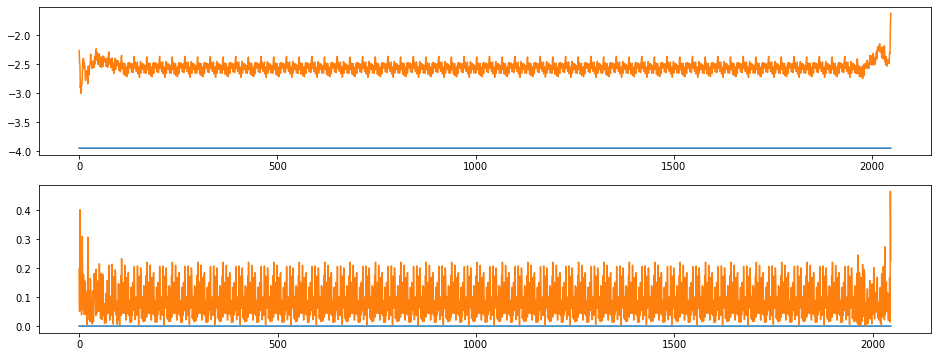

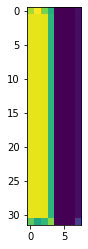

index:  24415
MAE:  1.3831546982721195
n_bunches       157
bunch_index     230
bunch_number     82
Name: 11206170, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6432/instability_data/06432_Inst_B1H_Q7_20171129_01h29m14s.h5


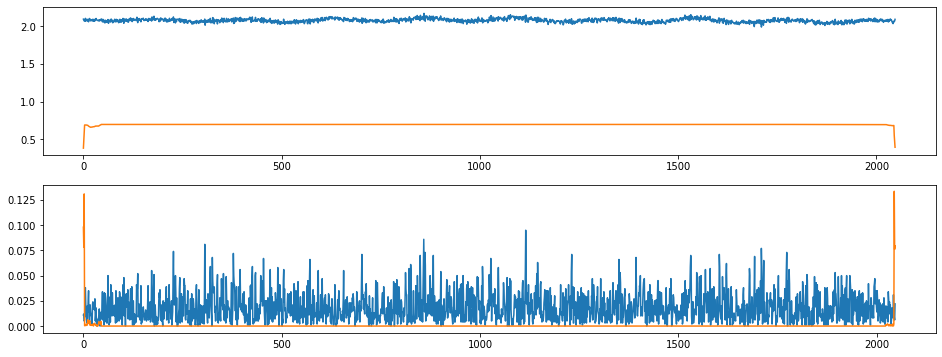

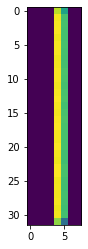

index:  88290
MAE:  1.3827339003685628
n_bunches       540
bunch_index     460
bunch_number    321
Name: 1157467, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7316/instability_data/07316_Inst_B1H_Q7_20181019_06h48m09s.h5


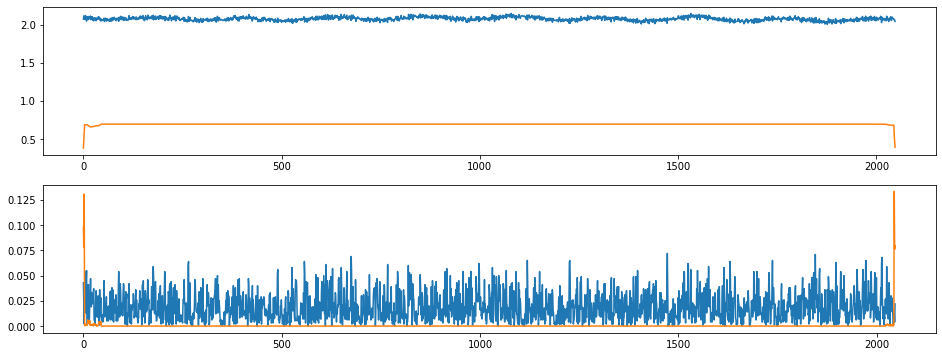

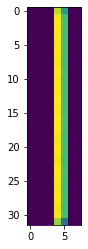

index:  16871
MAE:  1.3706158905474004
n_bunches       108
bunch_index     151
bunch_number     95
Name: 1357598, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7321/instability_data/07321_Inst_B1H_Q7_20181020_08h53m30s.h5


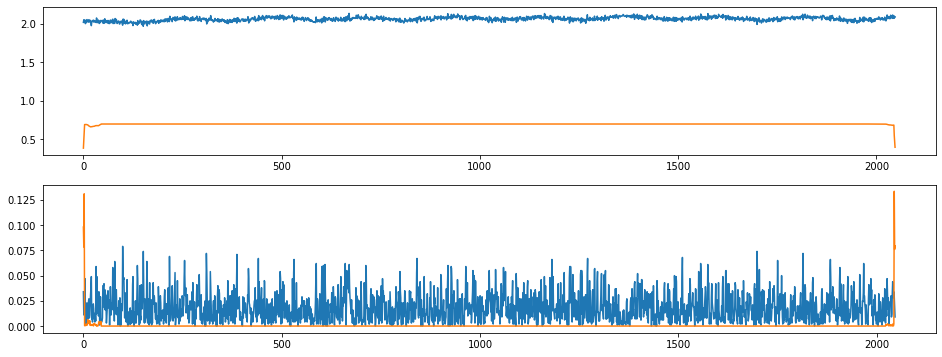

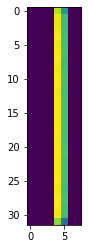

index:  84300
MAE:  1.37060367975384
n_bunches       1068
bunch_index      579
bunch_number     402
Name: 5148793, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7145/instability_data/07145_Inst_B1H_Q7_20180910_04h28m57s.h5


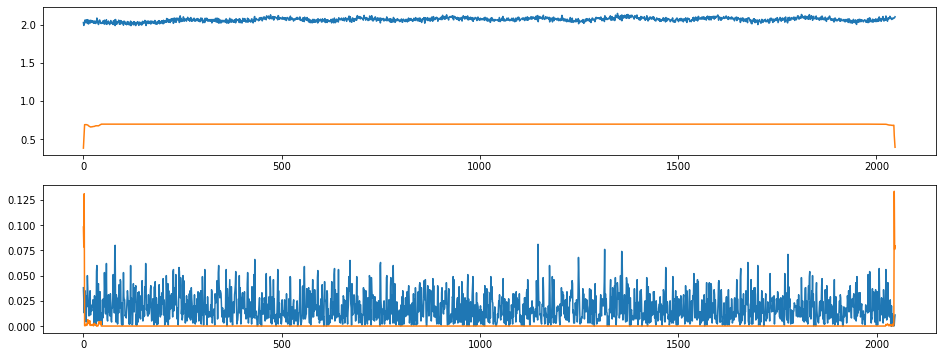

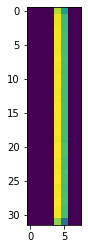

index:  88658
MAE:  1.3675748462287012
n_bunches       1868
bunch_index     3044
bunch_number    1630
Name: 4147049, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6364/instability_data/06364_Inst_B1H_Q7_20171106_20h01m14s.h5


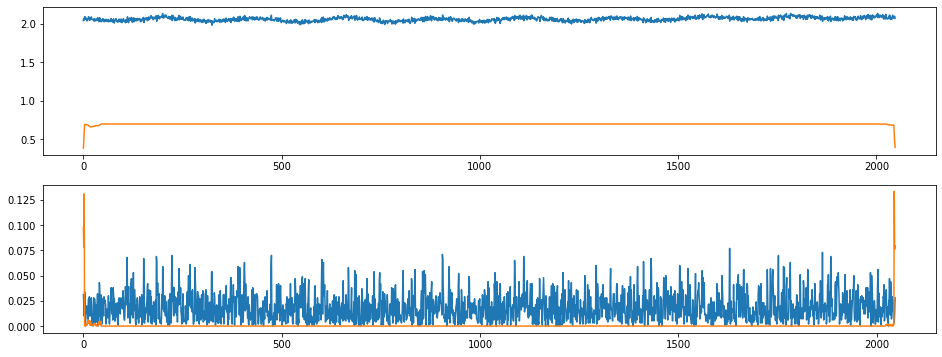

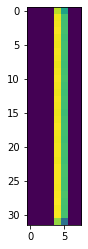

index:  23322
MAE:  1.3674103704724694
n_bunches       36
bunch_index     18
bunch_number    11
Name: 11626302, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6220/instability_data/06220_Inst_B1H_Q7_20170918_00h04m33s.h5


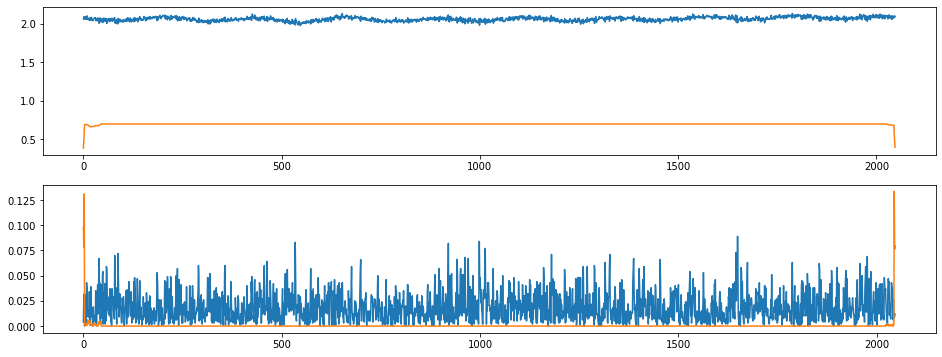

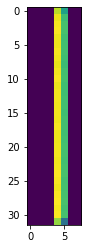

index:  23629
MAE:  1.3666985676464392
n_bunches        733
bunch_index     2064
bunch_number     434
Name: 10618248, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7485/instability_data/07485_Inst_B1H_Q7_20181129_23h12m15s.h5


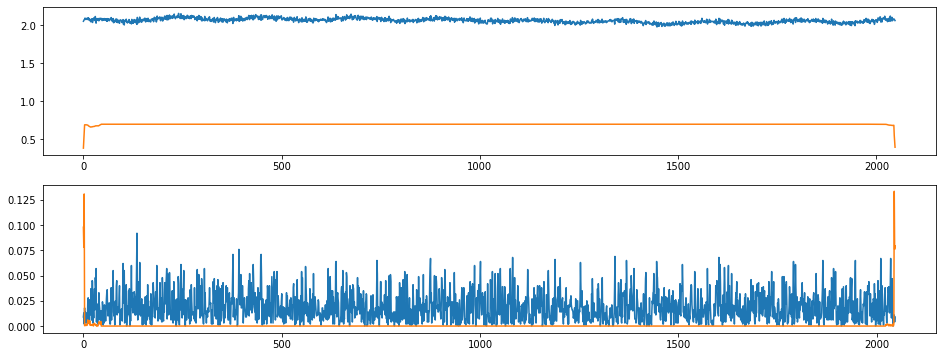

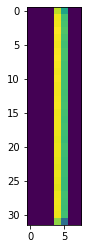

index:  84337
MAE:  1.3660758576096268
n_bunches       396
bunch_index     238
bunch_number     67
Name: 1268050, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6381/instability_data/06381_Inst_B1H_Q7_20171112_07h52m17s.h5


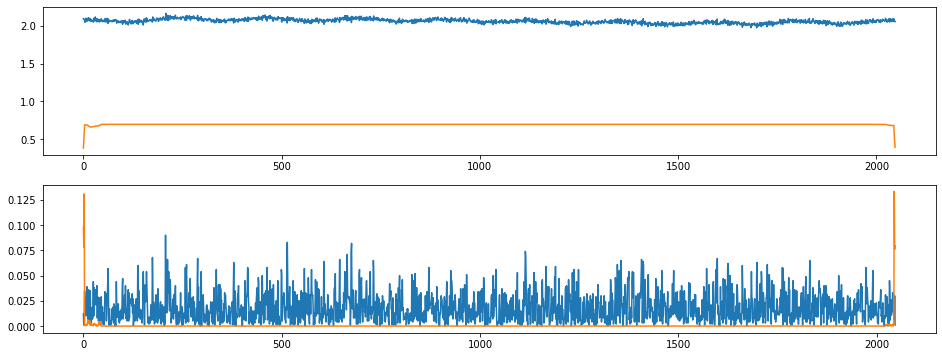

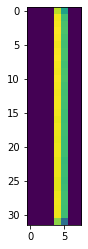

index:  24131
MAE:  1.357811871855054
n_bunches       2556
bunch_index     1942
bunch_number    1423
Name: 1943454, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6711/instability_data/06711_Inst_B1H_Q7_20180522_15h10m14s.h5


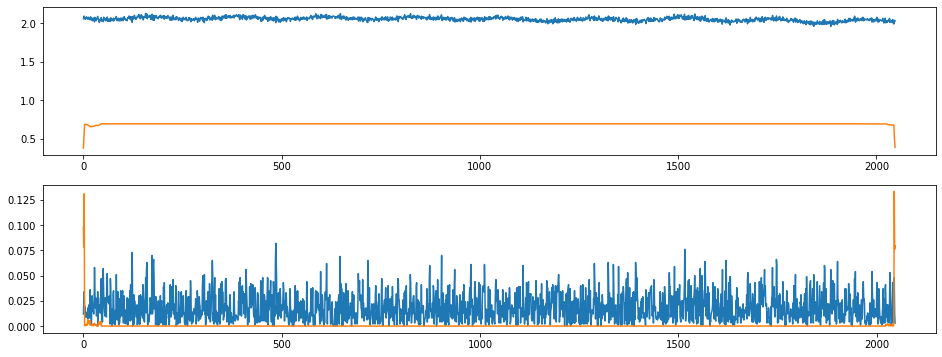

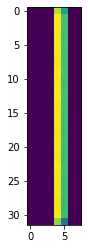

index:  83131
MAE:  1.3573918442650466
n_bunches       2556
bunch_index     2514
bunch_number    1860
Name: 7664387, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6659/instability_data/06659_Inst_B1H_Q7_20180509_05h04m16s.h5


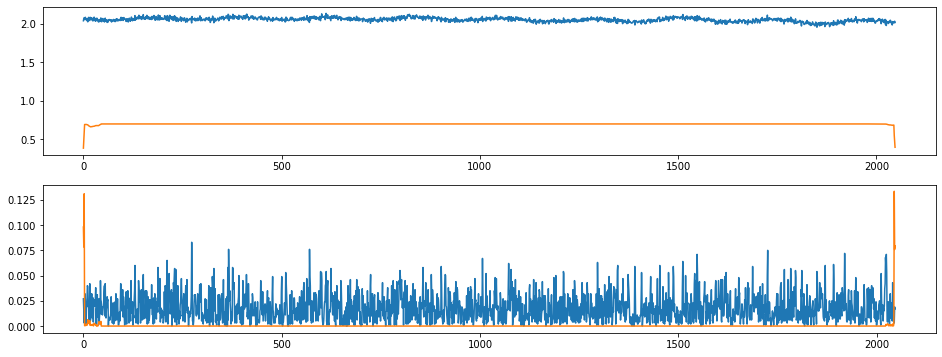

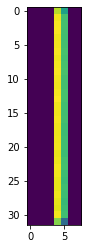

index:  84752
MAE:  1.3506266911085694
n_bunches       460
bunch_index     318
bunch_number     17
Name: 11147991, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7464/instability_data/07464_Inst_B1H_Q7_20181122_08h27m14s.h5


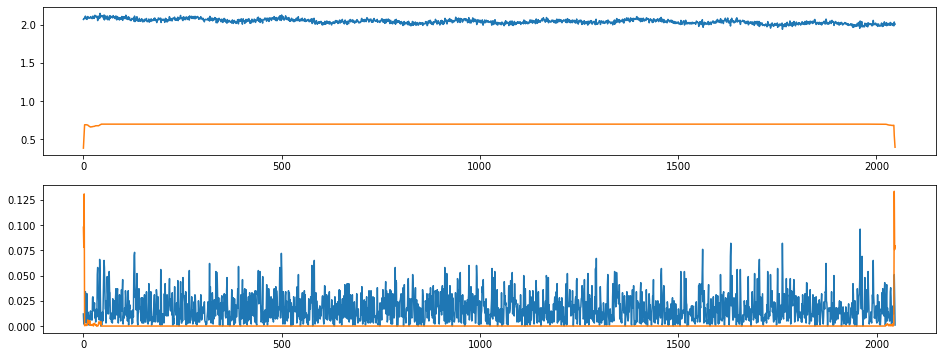

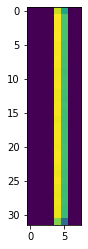

index:  19126
MAE:  1.3499506637055891
n_bunches       1868
bunch_index       70
bunch_number      29
Name: 9329122, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6411/instability_data/06411_Inst_B1H_Q7_20171122_22h29m42s.h5


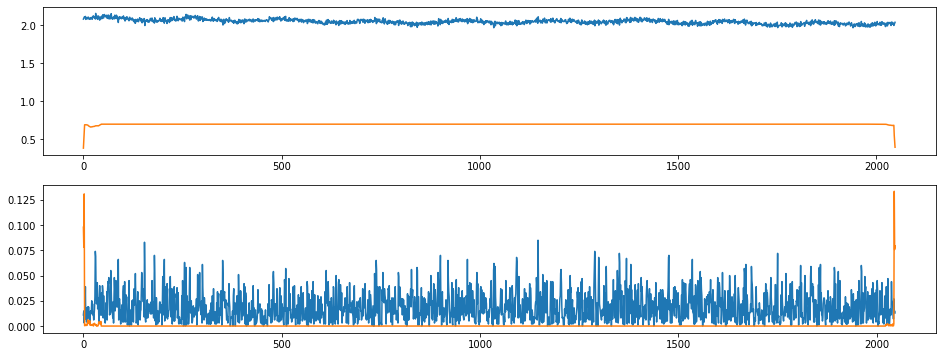

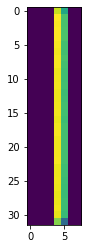

index:  18264
MAE:  1.3481702512563207
n_bunches       636
bunch_index     684
bunch_number    493
Name: 1511585, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7114/instability_data/07114_Inst_B1H_Q7_20180901_21h27m19s.h5


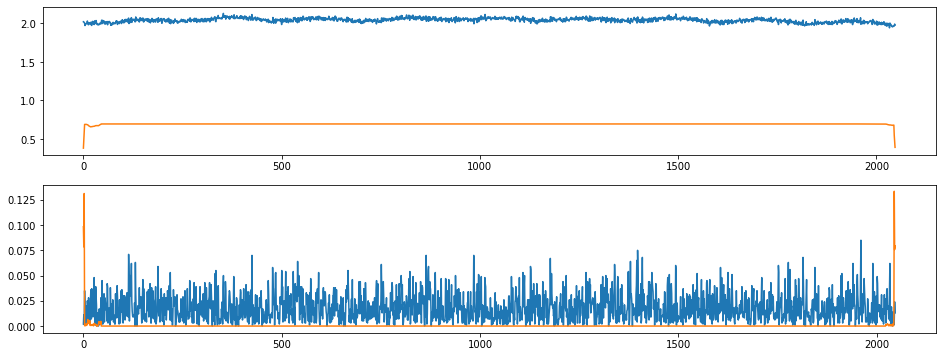

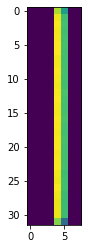

index:  366387
MAE:  1.3481409225814276
n_bunches       1868
bunch_index      412
bunch_number     213
Name: 614880, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6278/instability_data/06278_Inst_B1H_Q7_20171007_03h51m14s.h5


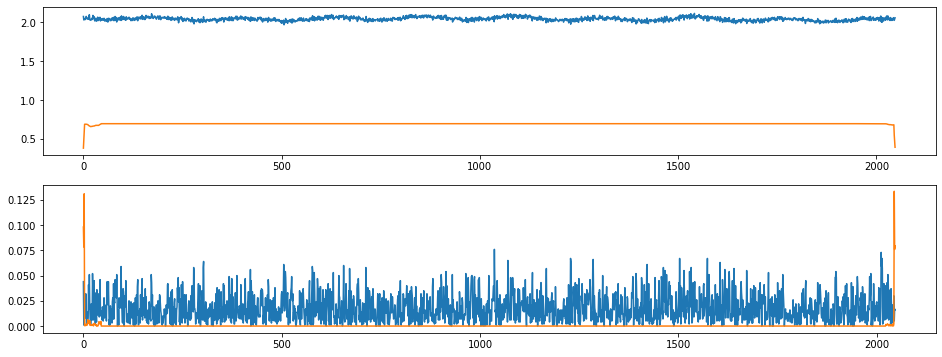

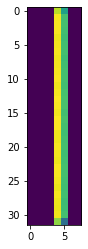

index:  86777
MAE:  1.3480567907152
n_bunches       1868
bunch_index     1134
bunch_number     610
Name: 9004549, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6275/instability_data/06275_Inst_B1H_Q7_20171006_09h11m21s.h5


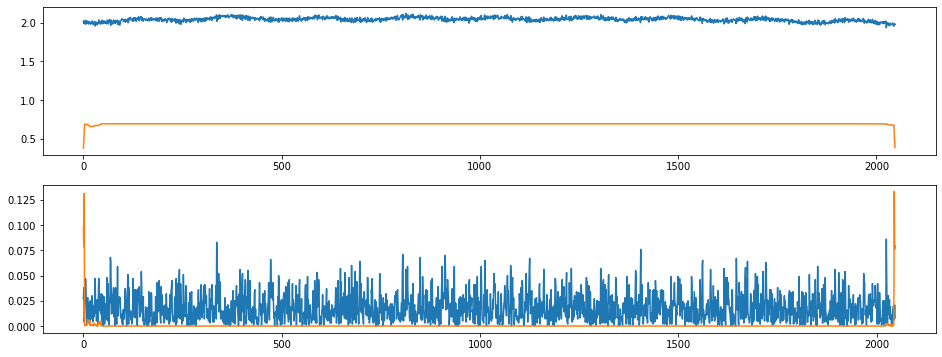

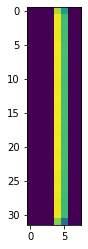

index:  367634
MAE:  1.3364345387960785
n_bunches       2556
bunch_index     2619
bunch_number    1930
Name: 2306747, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6709/instability_data/06709_Inst_B1H_Q7_20180521_02h43m14s.h5


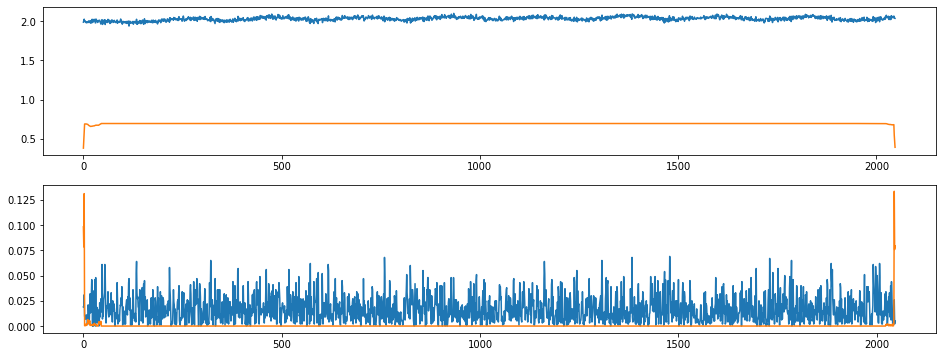

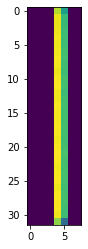

index:  367828
MAE:  1.3332901096052956
n_bunches       2556
bunch_index     2496
bunch_number    1861
Name: 9846423, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6919/instability_data/06919_Inst_B1H_Q7_20180713_17h11m14s.h5


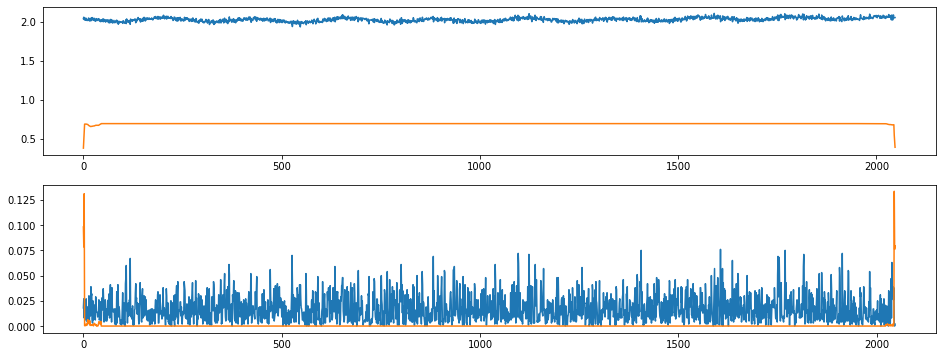

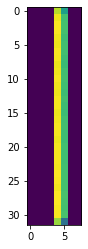

index:  365032
MAE:  1.3324751909390324
n_bunches       1260
bunch_index     2257
bunch_number    1219
Name: 10300769, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6284/instability_data/06284_Inst_B1H_Q7_20171008_16h46m39s.h5


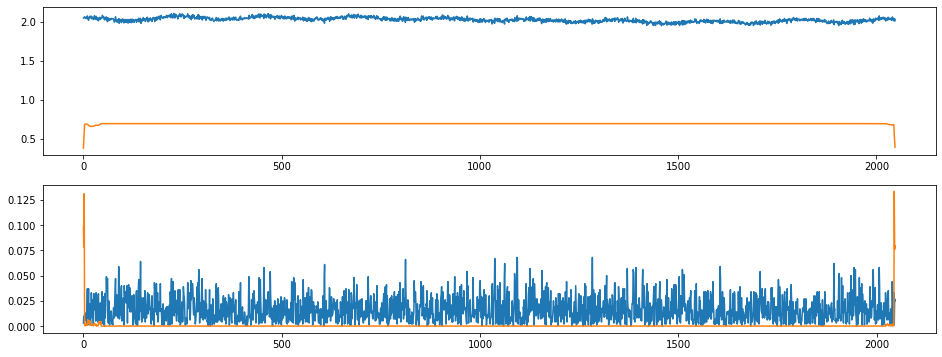

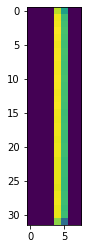

index:  366797
MAE:  1.3231323870003688
n_bunches       1068
bunch_index     1314
bunch_number     960
Name: 4906157, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7346/instability_data/07346_Inst_B1H_Q7_20181025_08h03m46s.h5


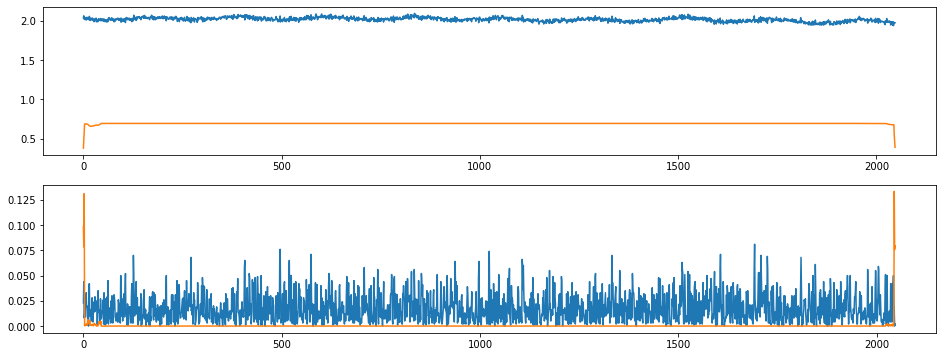

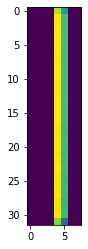

index:  365490
MAE:  1.3167338970922864
n_bunches       576
bunch_index     527
bunch_number     96
Name: 8324250, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7453/instability_data/07453_Inst_B1H_Q7_20181118_06h45m32s.h5


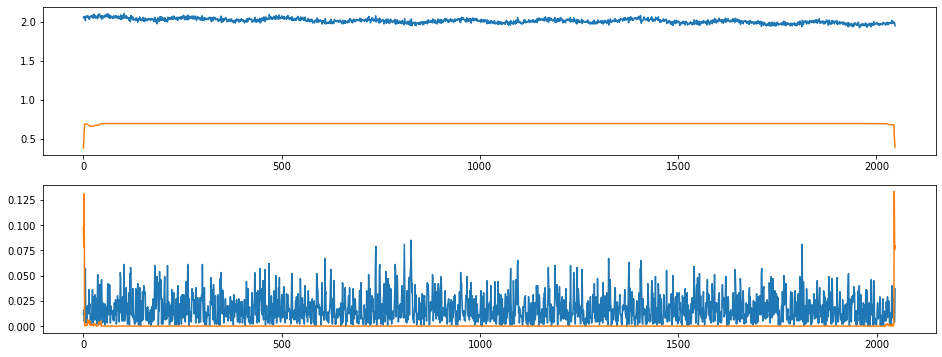

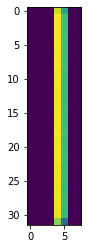

index:  366698
MAE:  1.3129176868757932
n_bunches       2556
bunch_index     2105
bunch_number    1566
Name: 8174612, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6215/instability_data/06215_Inst_B1H_Q7_20170917_00h53m13s.h5


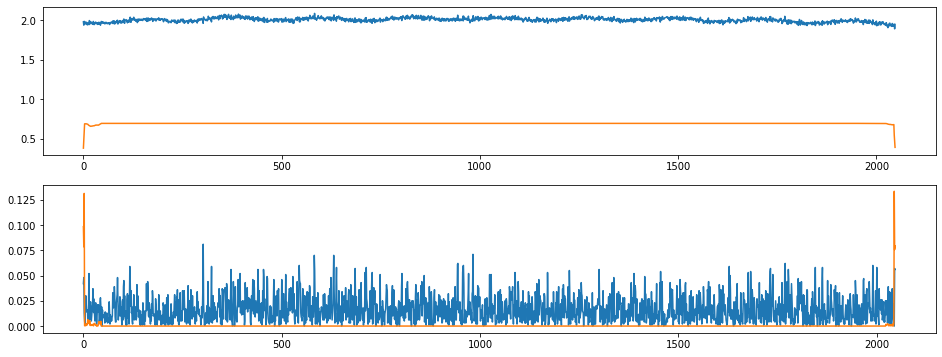

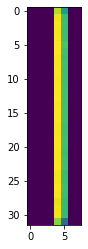

index:  91832
MAE:  1.0419922964589783
n_bunches        780
bunch_index     1174
bunch_number     635
Name: 4351642, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6341/instability_data/06341_Inst_B1H_Q7_20171028_00h03m16s.h5


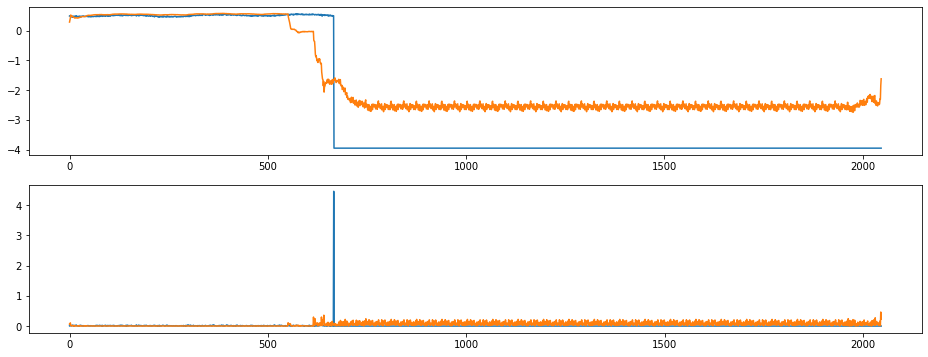

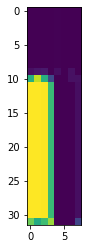

index:  203486
MAE:  1.0192138552392134
n_bunches       2175
bunch_index     3009
bunch_number    1951
Name: 3018478, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6694/instability_data/06694_Inst_B1H_Q7_20180517_11h10m14s.h5


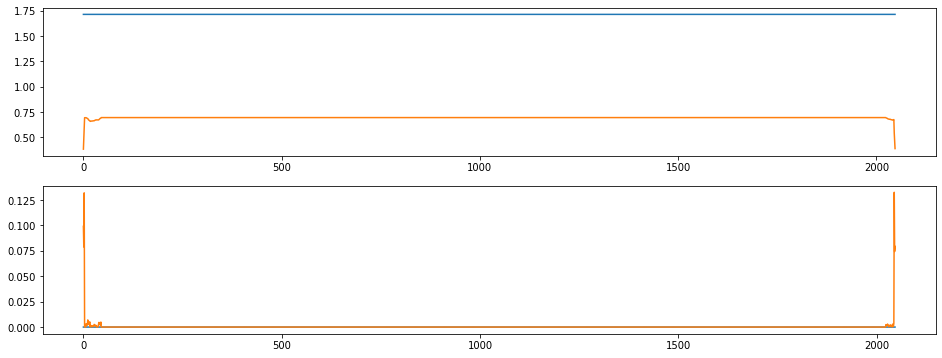

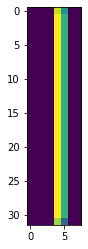

index:  360232
MAE:  0.9838247954193067
n_bunches        408
bunch_index     1965
bunch_number     267
Name: 5313199, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6436/instability_data/06436_Inst_B1H_Q7_20171130_04h40m40s.h5


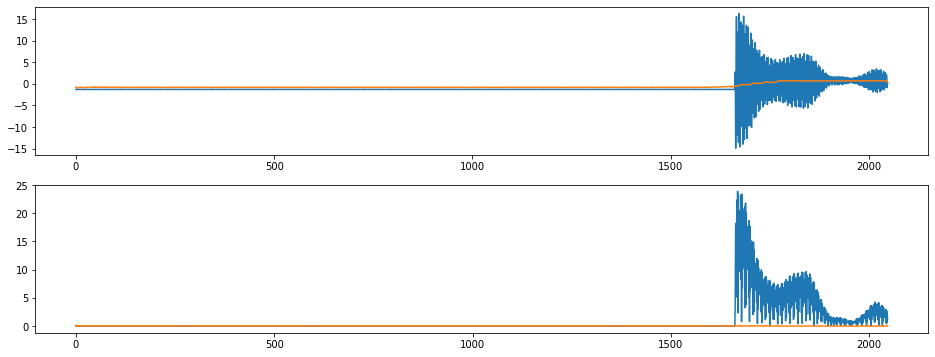

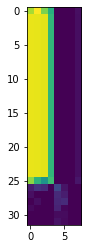

index:  263629
MAE:  0.9708401765078309
n_bunches       1452
bunch_index      194
bunch_number      68
Name: 8957998, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6891/instability_data/06891_Inst_B1H_Q7_20180706_18h47m14s.h5


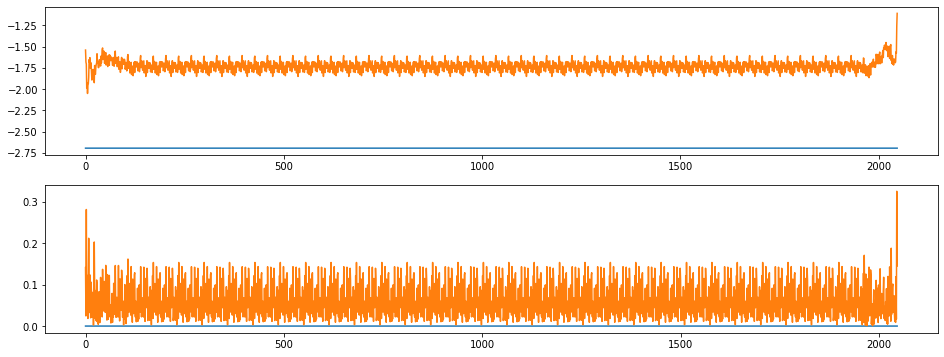

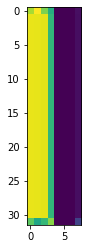

index:  266116
MAE:  0.9708401765078309
n_bunches       524
bunch_index     245
bunch_number     70
Name: 4293176, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6381/instability_data/06381_Inst_B1H_Q7_20171112_07h55m27s.h5


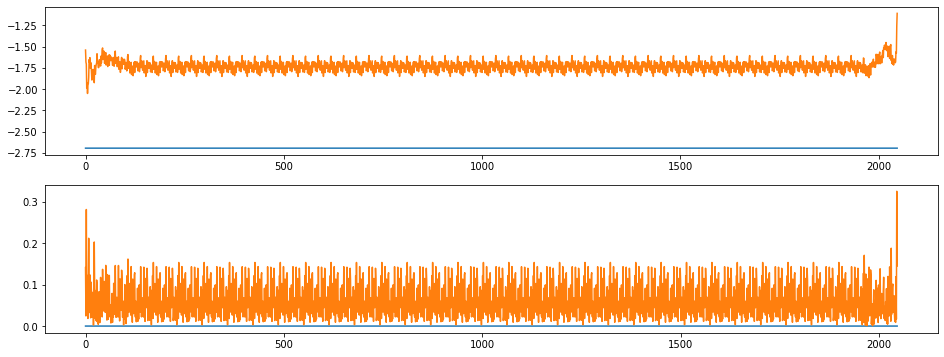

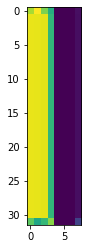

index:  266242
MAE:  0.9708401765078309
n_bunches       458
bunch_index     290
bunch_number     58
Name: 4454471, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6849/instability_data/06849_Inst_B1H_Q7_20180626_18h09m18s.h5


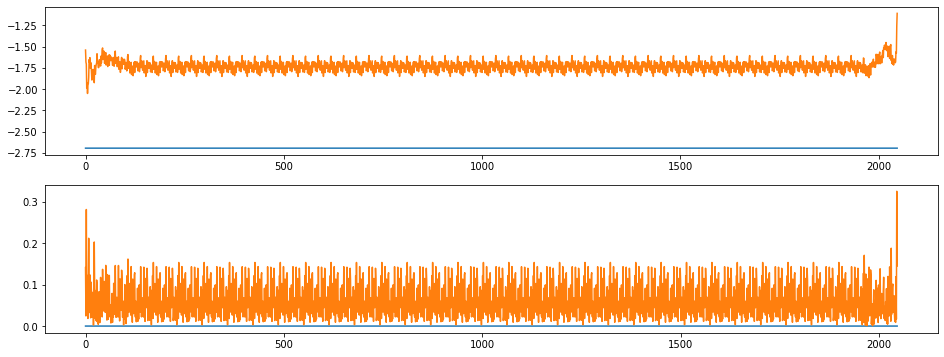

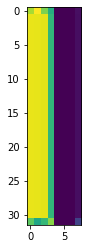

index:  268846
MAE:  0.9708401765078309
n_bunches       1868
bunch_index     1105
bunch_number     589
Name: 11078934, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6346/instability_data/06346_Inst_B1H_Q7_20171029_21h39m13s.h5


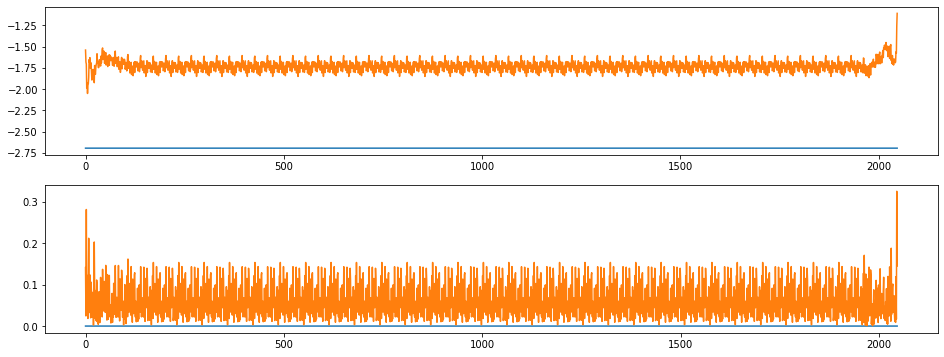

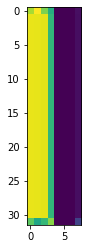

index:  269565
MAE:  0.9708401765078309
n_bunches        124
bunch_index     1747
bunch_number      71
Name: 6603532, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6868/instability_data/06868_Inst_B1H_Q7_20180630_10h54m51s.h5


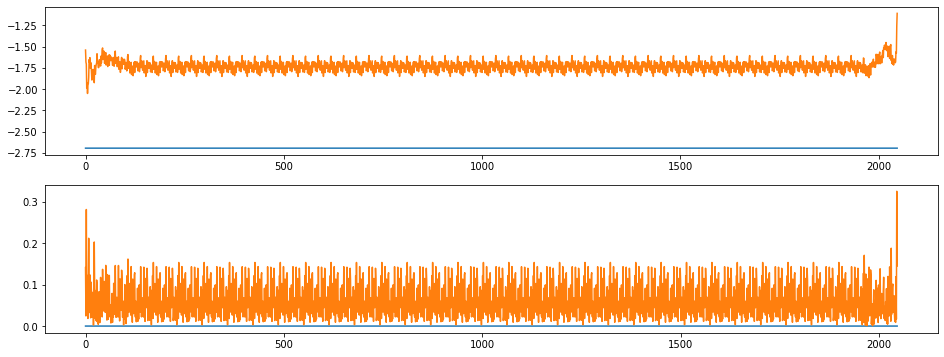

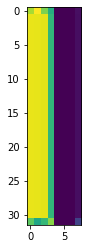

index:  265012
MAE:  0.9708401765078309
n_bunches       445
bunch_index     211
bunch_number    149
Name: 10658268, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6636/instability_data/06636_Inst_B1H_Q7_20180502_10h33m48s.h5


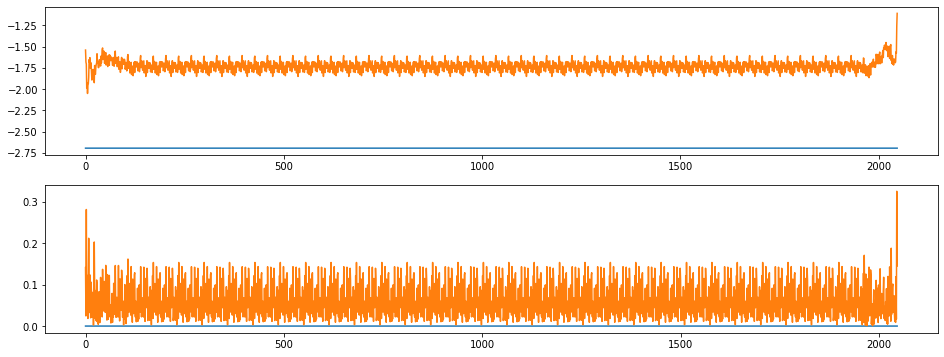

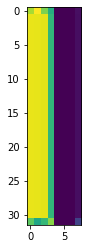

index:  108178
MAE:  0.924425700140652
n_bunches        339
bunch_index     1180
bunch_number     157
Name: 2103205, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6595/instability_data/06595_Inst_B1H_Q7_20180423_04h08m14s.h5


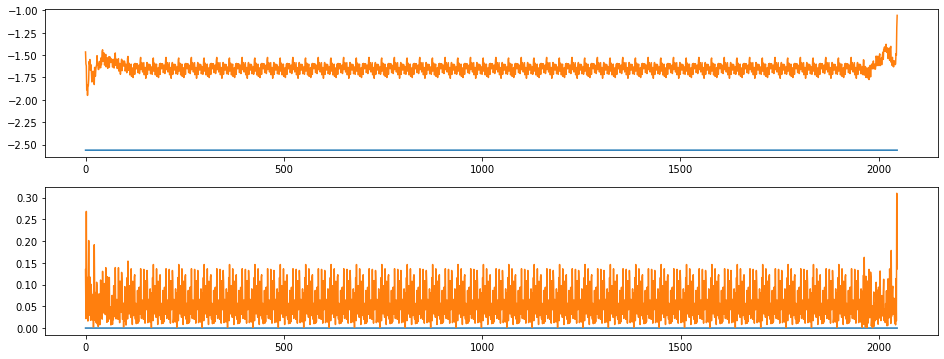

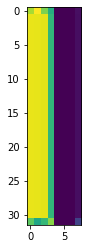

index:  111618
MAE:  0.924425700140652
n_bunches       2556
bunch_index     2564
bunch_number    1894
Name: 6954426, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6919/instability_data/06919_Inst_B1H_Q7_20180713_11h01m15s.h5


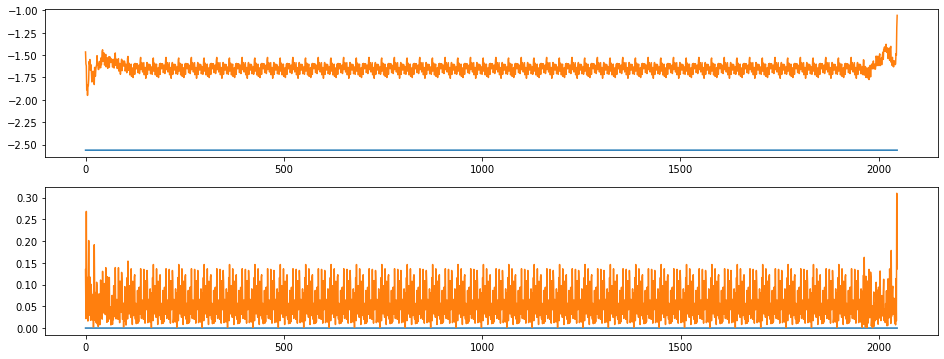

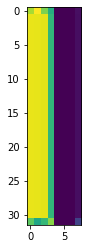

index:  113557
MAE:  0.924425700140652
n_bunches       2556
bunch_index     2225
bunch_number    1630
Name: 9992888, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6700/instability_data/06700_Inst_B1H_Q7_20180519_10h59m14s.h5


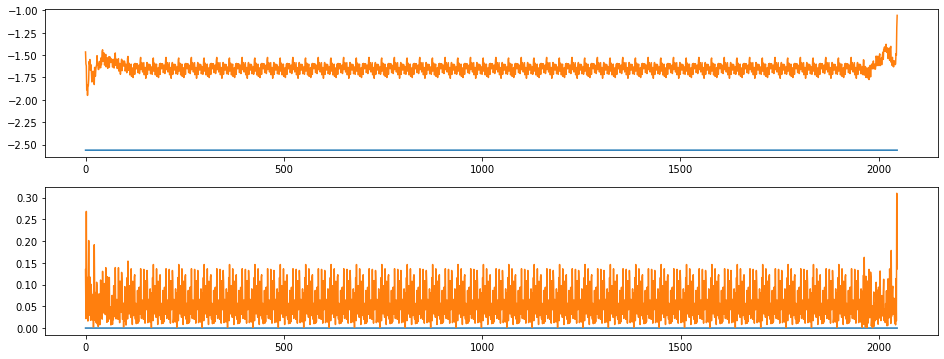

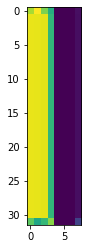

index:  110975
MAE:  0.924425700140652
n_bunches       1551
bunch_index     3060
bunch_number    1374
Name: 11534149, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6628/instability_data/06628_Inst_B1H_Q7_20180430_22h46m14s.h5


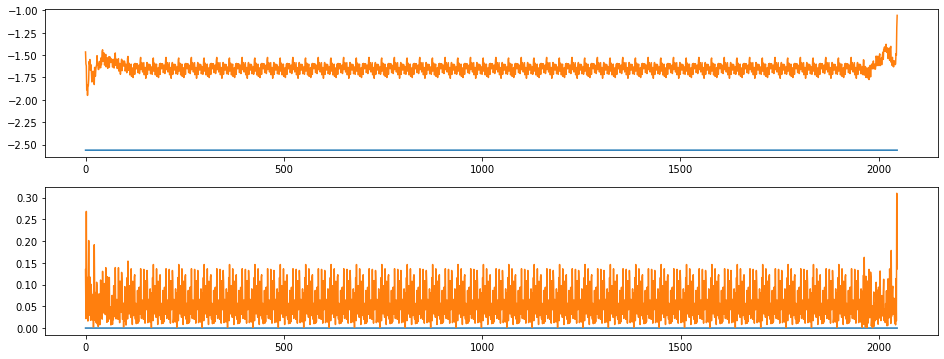

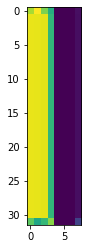

index:  349963
MAE:  0.9087204679367136
n_bunches       108
bunch_index      98
bunch_number     49
Name: 4796559, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7322/instability_data/07322_Inst_B1H_Q7_20181021_03h24m15s.h5


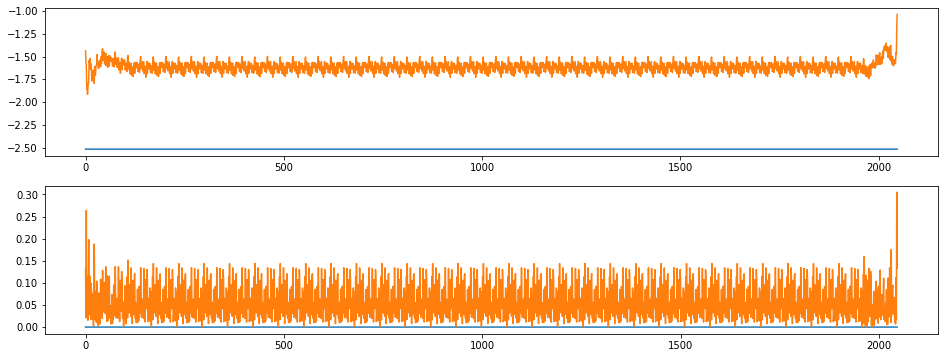

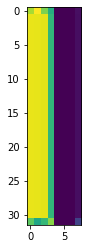

index:  344851
MAE:  0.9087204679367136
n_bunches       780
bunch_index     519
bunch_number    282
Name: 186025, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6362/instability_data/06362_Inst_B1H_Q7_20171104_17h37m09s.h5


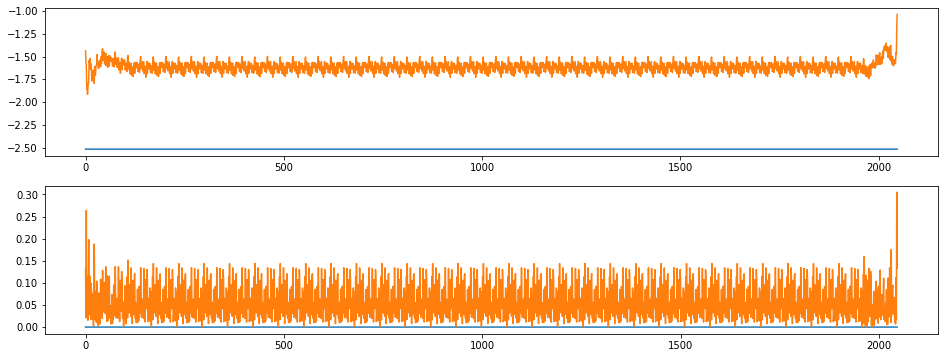

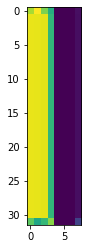

index:  348578
MAE:  0.9087204679367136
n_bunches       652
bunch_index     193
bunch_number     35
Name: 5828207, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6382/instability_data/06382_Inst_B1H_Q7_20171112_15h41m20s.h5


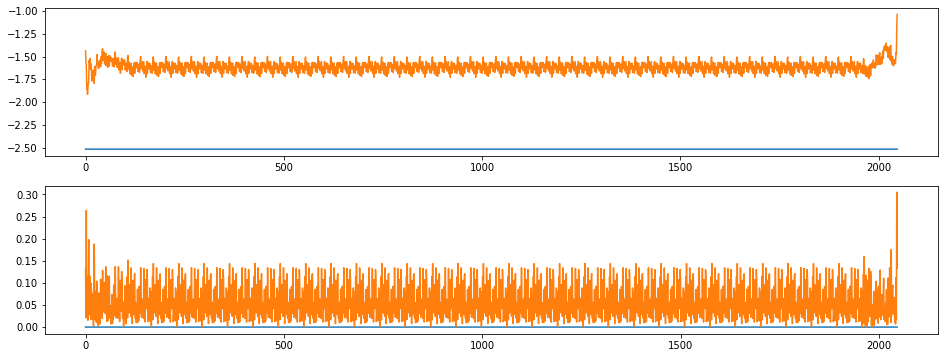

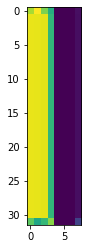

index:  346158
MAE:  0.9087204679367136
n_bunches       1836
bunch_index     2770
bunch_number    1470
Name: 8262603, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6272/instability_data/06272_Inst_B1H_Q7_20171005_03h56m13s.h5


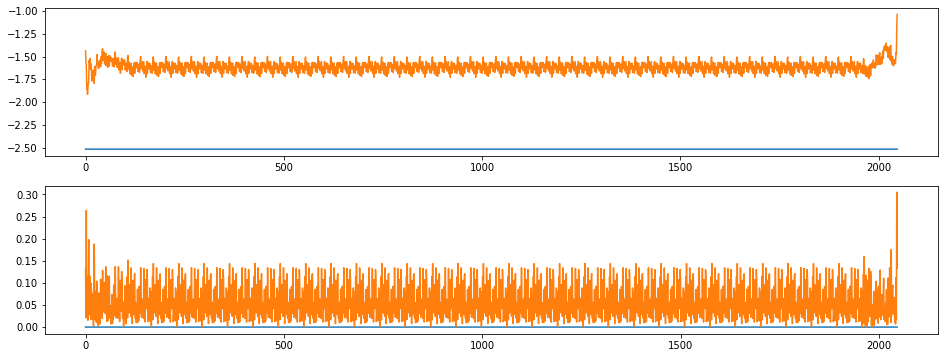

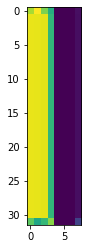

index:  129608
MAE:  0.9065847133914267
n_bunches       602
bunch_index     602
bunch_number    254
Name: 2904398, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7036/instability_data/07036_Inst_B1H_Q7_20180807_20h37m58s.h5


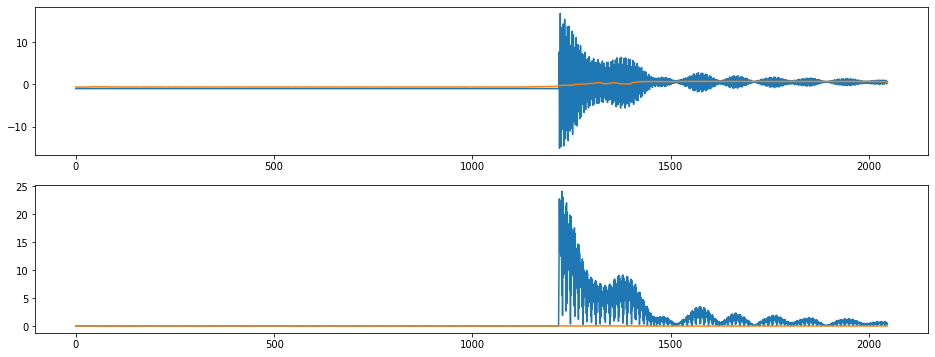

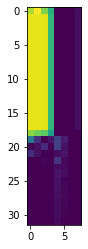

index:  202720
MAE:  0.8787904134260647
n_bunches       1868
bunch_index     2524
bunch_number    1371
Name: 1721646, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6362/instability_data/06362_Inst_B1H_Q7_20171104_22h19m14s.h5


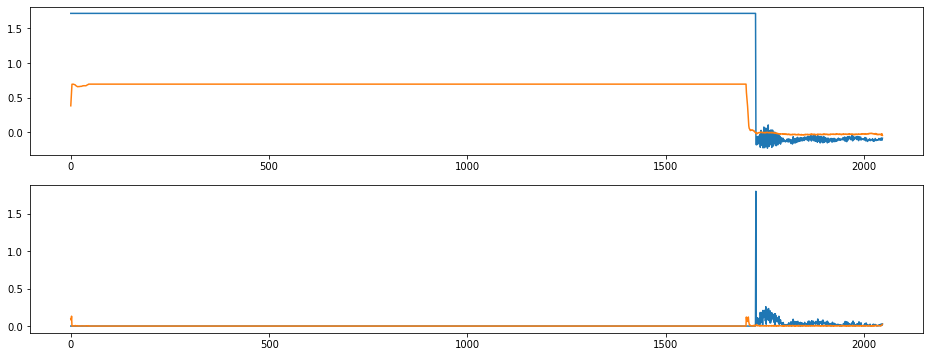

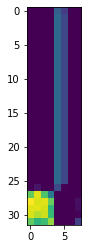

index:  158900
MAE:  0.8671075042383746
n_bunches       2556
bunch_index     1511
bunch_number    1093
Name: 4333792, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6650/instability_data/06650_Inst_B1H_Q7_20180507_12h45m14s.h5


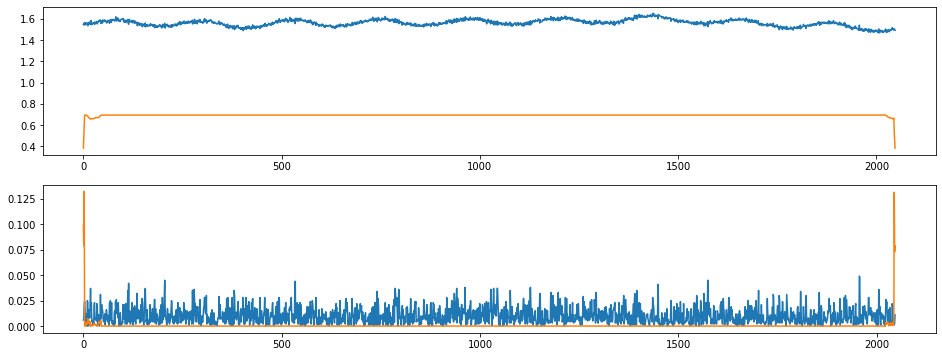

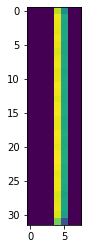

index:  163595
MAE:  0.8545216204178288
n_bunches       1551
bunch_index     2197
bunch_number    1020
Name: 6837386, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6628/instability_data/06628_Inst_B1H_Q7_20180501_07h12m13s.h5


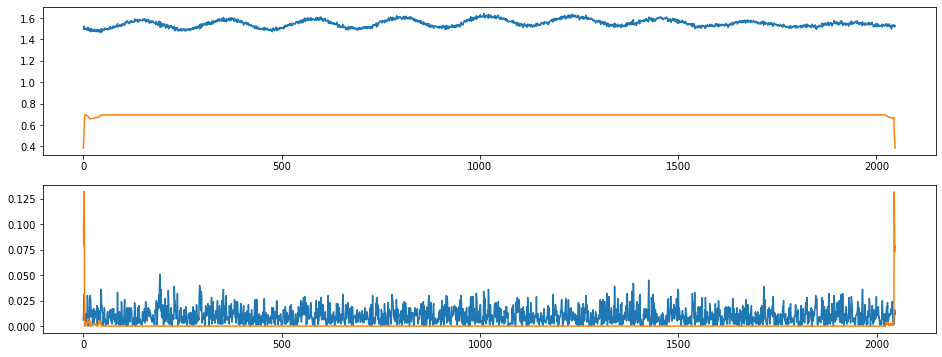

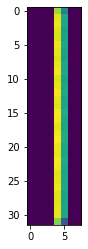

index:  156748
MAE:  0.8463317201151512
n_bunches       172
bunch_index      58
bunch_number     21
Name: 2356368, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6362/instability_data/06362_Inst_B1H_Q7_20171104_17h28m46s.h5


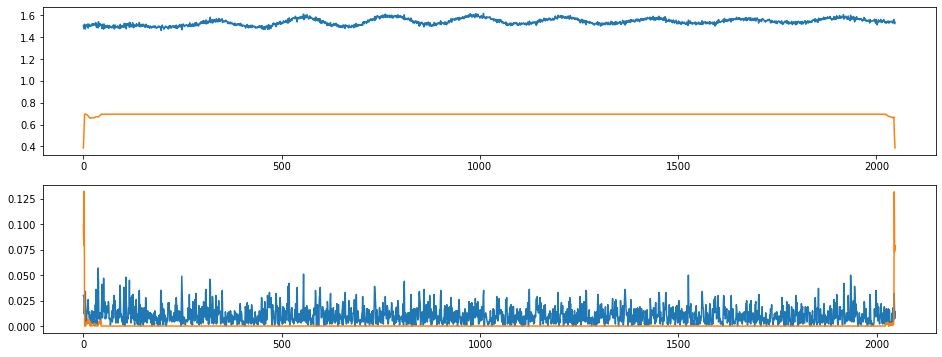

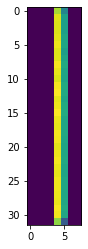

In [37]:
for i in range(50):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]
    
    encoding_output = encoding_model(train_dataset[anomalous_index][None, :])

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()